In [236]:
%pip install torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Very first thing is to clean our data. Let's make a csv file with only the relevant columns:
import pandas as pd
import numpy as np


# Edit the next line to pick what we are researching
research = 'loan'

file_path = f'data/{research}_data.csv'  
    
# Rename FIRST
df = pd.read_csv(file_path, dtype=str, low_memory=False)
df.rename(columns={'derived_race': 'race', 'derived_sex': 'sex'}, inplace=True)
df['race'] = df['race'].replace({'Black or African American': 'Black'})

col = "sex"
unique_count = df[col].nunique()
    

print(f"Unique values: {unique_count}") 
print(df[col].value_counts())
print(len(df))
# Use the renamed column names
selected_columns = [
    'derived_dwelling_category', 'conforming_loan_limit', 'race', 'sex', 'action_taken', 'loan_type', 'loan_purpose',
    'lien_status', 'reverse_mortgage', 'open-end_line_of_credit', 'business_or_commercial_purpose', 'loan_amount', 'loan_to_value_ratio', 'hoepa_status', 'loan_term', 'negative_amortization', 'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features',
    'property_value', 'occupancy_type', 'manufactured_home_secured_property_type', 'manufactured_home_land_property_interest',
    'income', 'debt_to_income_ratio', 'applicant_credit_score_type', 'applicant_race_observed', 'applicant_sex_observed', 'applicant_age', 
    'tract_population', 'tract_minority_population_percent', 'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage'
]
df = df[selected_columns]

# Now use renamed 'race' safely
categorical_features = ['derived_dwelling_category', 'conforming_loan_limit', 'race', 'sex', 'loan_type', 'loan_purpose', 'lien_status',
                        'reverse_mortgage', 'open-end_line_of_credit', 'business_or_commercial_purpose', 'hoepa_status', 'negative_amortization', 'interest_only_payment',
                        'balloon_payment', 'other_nonamortizing_features', 'occupancy_type', 'manufactured_home_secured_property_type', 'manufactured_home_land_property_interest',
                        'debt_to_income_ratio', 'applicant_credit_score_type', 'applicant_race_observed', 'applicant_sex_observed', 'applicant_age']

numeric_features = [col for col in df.columns if col not in categorical_features + ['action_taken']]
# Drop rows with invalid categorical values
invalid_vals = ['', 'nan', 'NaN', 'NA', 'Exempt']
df.replace(invalid_vals, np.nan, inplace=True)
df = df[~df[categorical_features].astype(str).isin(invalid_vals).any(axis=1)]

# Create target
df['target'] = df['action_taken'].map({'1': 1, '3': 0})
df = df.dropna()

# Finalize

    

print(len(df.columns))

    

Unique values: 4
sex
Joint                158558
Male                 146240
Female                99213
Sex Not Available      2740
Name: count, dtype: int64
406751
                   derived_dwelling_category conforming_loan_limit   race  \
0       Single Family (1-4 Units):Site-Built                     C  Asian   
1       Single Family (1-4 Units):Site-Built                     C  White   
2       Single Family (1-4 Units):Site-Built                     C  White   
3       Single Family (1-4 Units):Site-Built                     C  White   
5       Single Family (1-4 Units):Site-Built                     C  White   
...                                      ...                   ...    ...   
406745  Single Family (1-4 Units):Site-Built                     C  White   
406746  Single Family (1-4 Units):Site-Built                     C  Asian   
406747  Single Family (1-4 Units):Site-Built                     C  White   
406748  Single Family (1-4 Units):Site-Built                    

In [ ]:
# We want to divide our data into training, evaluation, and testing sets
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X = df.drop(columns=['target', 'action_taken'])
y = df['target']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])


X_train_eval, X_test, y_train_eval, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train_eval, y_train_eval, stratify=y_train_eval, test_size=0.125, random_state=42)

# Fit only on training
print(f"Training set size: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Evaluation set size: {len(X_eval)} ({len(X_eval)/len(df)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")


# Scale all data fit to training data only.
X_train_scaled = preprocessor.fit_transform(X_train)
X_eval_scaled = preprocessor.transform(X_eval)
X_test_scaled = preprocessor.transform(X_test)
X_scaled= preprocessor.transform(X)


feature_names = [name.split('__')[1] for name in preprocessor.get_feature_names_out()]
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names, index=X.index)
df_with_target = X_scaled_df.copy()

df_with_target['target'] = y



Training set size: 258328 (70.0%)
Evaluation set size: 36905 (10.0%)
Test set size: 73809 (20.0%)
Index(['loan_amount', 'loan_to_value_ratio', 'loan_term', 'property_value',
       'income', 'tract_population', 'tract_minority_population_percent',
       'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',
       'derived_dwelling_category_Single Family (1-4 Units):Manufactured',
       ...
       'applicant_sex_observed_3', 'applicant_age_25-34',
       'applicant_age_35-44', 'applicant_age_45-54', 'applicant_age_55-64',
       'applicant_age_65-74', 'applicant_age_8888', 'applicant_age_<25',
       'applicant_age_>74', 'target'],
      dtype='object', length=110)


In [273]:
# Train a simple logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = logreg.predict(X_eval_scaled)
y_prob = logreg.predict_proba(X_eval_scaled)[:, 1]

accuracy = accuracy_score(y_eval, y_pred)
auc = roc_auc_score(y_eval, y_prob)
report = classification_report(y_eval, y_pred, output_dict=True)

print(f"Accuracy: {accuracy:.6f}, \nAUC: {auc:.6f}, \nPrecision: {report['1']['precision']:.6f},\nRecall: {report['1']['recall']:.6f}, \nF1: {report['1']['f1-score']:.6f}")


Accuracy: 0.973852, 
AUC: 0.996313, 
Precision: 0.987354,
Recall: 0.978086, 
F1: 0.982698


In [288]:
# Mostly for testing, we want to make sure we are not including variables that only can take on certain values because of the dependent variable.
# Only can use features that come about before the outcome is decided.
# Get feature names

# Get coefficients
coefs = logreg.coef_[0]  # shape: (n_features,)

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs,
    'abs_coef': np.abs(coefs)
})

# Sort by magnitude of coefficient
importance_df = importance_df.sort_values(by='abs_coef', ascending=False)

print(importance_df.head(50))  # Top 20 most influential features

                                               feature  coefficient  abs_coef
42                                      hoepa_status_3    -7.479743  7.479743
41                                      hoepa_status_2     6.142055  6.142055
84                           debt_to_income_ratio_>60%    -4.016116  4.016116
55                                    occupancy_type_1    -2.205969  2.205969
52                      other_nonamortizing_features_1     1.836770  1.836770
54                      other_nonamortizing_features_2    -1.738027  1.738027
82                        debt_to_income_ratio_50%-60%    -1.552220  1.552220
56                                    occupancy_type_2     1.452013  1.452013
40                                      hoepa_status_1     1.436435  1.436435
43                             negative_amortization_1     1.296269  1.296269
45                             negative_amortization_2    -1.197526  1.197526
25                                      loan_purpose_1     1.185

In [275]:
# Now we train a CNN instead, just to compare results
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [276]:
# Prepare the data
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)  # Add channel dim
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_eval_tensor = torch.tensor(X_eval_scaled, dtype=torch.float32).unsqueeze(1)
y_eval_tensor = torch.tensor(y_eval.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

total_dataset = TensorDataset(X_tensor, y_tensor)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
eval_dataset = TensorDataset(X_eval_tensor, y_eval_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

total_loader = DataLoader(total_dataset, batch_size=2048)
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=2048)
test_loader = DataLoader(test_dataset, batch_size=2048)

class TabularMLP(nn.Module):
    def __init__(self, input_len):
        super(TabularMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_len, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.squeeze(1)  
        return self.model(x)

# Instantiate model
def instantiate_model():
    model = TabularMLP(input_len=X_train_scaled.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    return model, criterion, optimizer

model, criterion, optimizer = instantiate_model()

In [277]:
def evaluate(verbose=False):
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(X_eval_tensor).numpy()
        y_pred_label = (y_pred_prob > 0.5).astype(int)
    y_true = y_eval_tensor.numpy().astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    if(verbose):
        auc = roc_auc_score(y_true, y_pred_prob)
        report = classification_report(y_true, y_pred_label, output_dict=True)
        print(f"Accuracy: {accuracy}, \nAUC: {auc}, \nPrecision: {report['1']['precision']},\nRecall: {report['1']['recall']}, \nF1: {report['1']['f1-score']}")
    return accuracy

#Same thing, just on the test set
def test(verbose=False):
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(X_test_tensor).numpy()
        y_pred_label = (y_pred_prob > 0.5).astype(int)
    y_true = y_test_tensor.numpy().astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    if(verbose):
        auc = roc_auc_score(y_true, y_pred_prob)
        report = classification_report(y_true, y_pred_label, output_dict=True)
        print(f"Accuracy: {accuracy}, \nAUC: {auc}, \nPrecision: {report['1']['precision']},\nRecall: {report['1']['recall']}, \nF1: {report['1']['f1-score']}")
    return accuracy

In [278]:
# Training loop
train = True
from pathlib import Path
model_save_filepath = f'mlp_models_unscaled/baselineCNN_{research}'
if(train):
    model, criterion, optimizer = instantiate_model()
    max_eval_accuracy = 0
    max_epochs = 1000
    max_epochs_without_improvement = 50
    current_epochs_without_improvement = 0
    if Path(model_save_filepath).exists():
        model.load_state_dict(torch.load(model_save_filepath, weights_only=True))
        max_eval_accuracy = evaluate()
    for epoch in range(max_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        print(f"Epoch {epoch+1} loss: {epoch_loss:.4f}")
        # Evaluate
        model.eval()
        with torch.no_grad():
            predictions = model(X_eval_tensor)
            predicted_classes = (predictions > 0.5).float()
        accuracy = (predicted_classes == y_eval_tensor).float().mean().item()
        print(f"Evaluation Accuracy: {accuracy:.4f}")
        if(accuracy > max_eval_accuracy):
            torch.save(model.state_dict(), model_save_filepath)
            current_epochs_without_improvement = 0
            max_eval_accuracy = accuracy
            print("Saved model")
        else:
            current_epochs_without_improvement += 1
            if current_epochs_without_improvement > max_epochs_without_improvement:
                break
else:
    if Path(model_save_filepath).exists():
        model.load_state_dict(torch.load(model_save_filepath, weights_only=True))
        max_eval_accuracy = evaluate()


Epoch 1 loss: 88.2231
Evaluation Accuracy: 0.6376
Saved model
Epoch 2 loss: 86.7591
Evaluation Accuracy: 0.7549
Saved model
Epoch 3 loss: 85.1982
Evaluation Accuracy: 0.7592
Saved model
Epoch 4 loss: 83.5635
Evaluation Accuracy: 0.7592
Saved model
Epoch 5 loss: 81.8059
Evaluation Accuracy: 0.7592
Epoch 6 loss: 79.8678
Evaluation Accuracy: 0.7592
Epoch 7 loss: 77.7915
Evaluation Accuracy: 0.7592
Epoch 8 loss: 75.7180
Evaluation Accuracy: 0.7592
Epoch 9 loss: 73.7355
Evaluation Accuracy: 0.7592
Epoch 10 loss: 71.8523
Evaluation Accuracy: 0.7592
Epoch 11 loss: 70.0949
Evaluation Accuracy: 0.7592
Epoch 12 loss: 68.4224
Evaluation Accuracy: 0.7592
Epoch 13 loss: 66.8688
Evaluation Accuracy: 0.7592
Epoch 14 loss: 65.4491
Evaluation Accuracy: 0.7592
Epoch 15 loss: 64.0514
Evaluation Accuracy: 0.7592
Epoch 16 loss: 62.7777
Evaluation Accuracy: 0.7592
Epoch 17 loss: 61.4919
Evaluation Accuracy: 0.7592
Epoch 18 loss: 60.2345
Evaluation Accuracy: 0.7592
Epoch 19 loss: 58.9797
Evaluation Accuracy:

In [279]:
# Evaluate

model.load_state_dict(torch.load(model_save_filepath, weights_only=True))
evaluate(verbose=True)
test(verbose=True)


Accuracy: 0.9768324075328546, 
AUC: 0.9970354711796199, 
Precision: 0.9889832949308756,
Recall: 0.9804061529676291, 
F1: 0.9846760462407026
Accuracy: 0.9759514422360417, 
AUC: 0.9967877933419891, 
Precision: 0.9886177397568663,
Recall: 0.979602398458134, 
F1: 0.9840894219306029


0.9759514422360417

In [289]:
# Now we experiment
# This can mostly be done for the final project step, but let's do a similar analysis to HW1, seeing the bias in the data itself.
from matplotlib import pyplot as plt


Index(['loan_amount', 'loan_to_value_ratio', 'loan_term', 'property_value',
       'income', 'tract_population', 'tract_minority_population_percent',
       'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',
       'derived_dwelling_category_Single Family (1-4 Units):Manufactured',
       ...
       'applicant_sex_observed_3', 'applicant_age_25-34',
       'applicant_age_35-44', 'applicant_age_45-54', 'applicant_age_55-64',
       'applicant_age_65-74', 'applicant_age_8888', 'applicant_age_<25',
       'applicant_age_>74', 'target'],
      dtype='object', length=110)


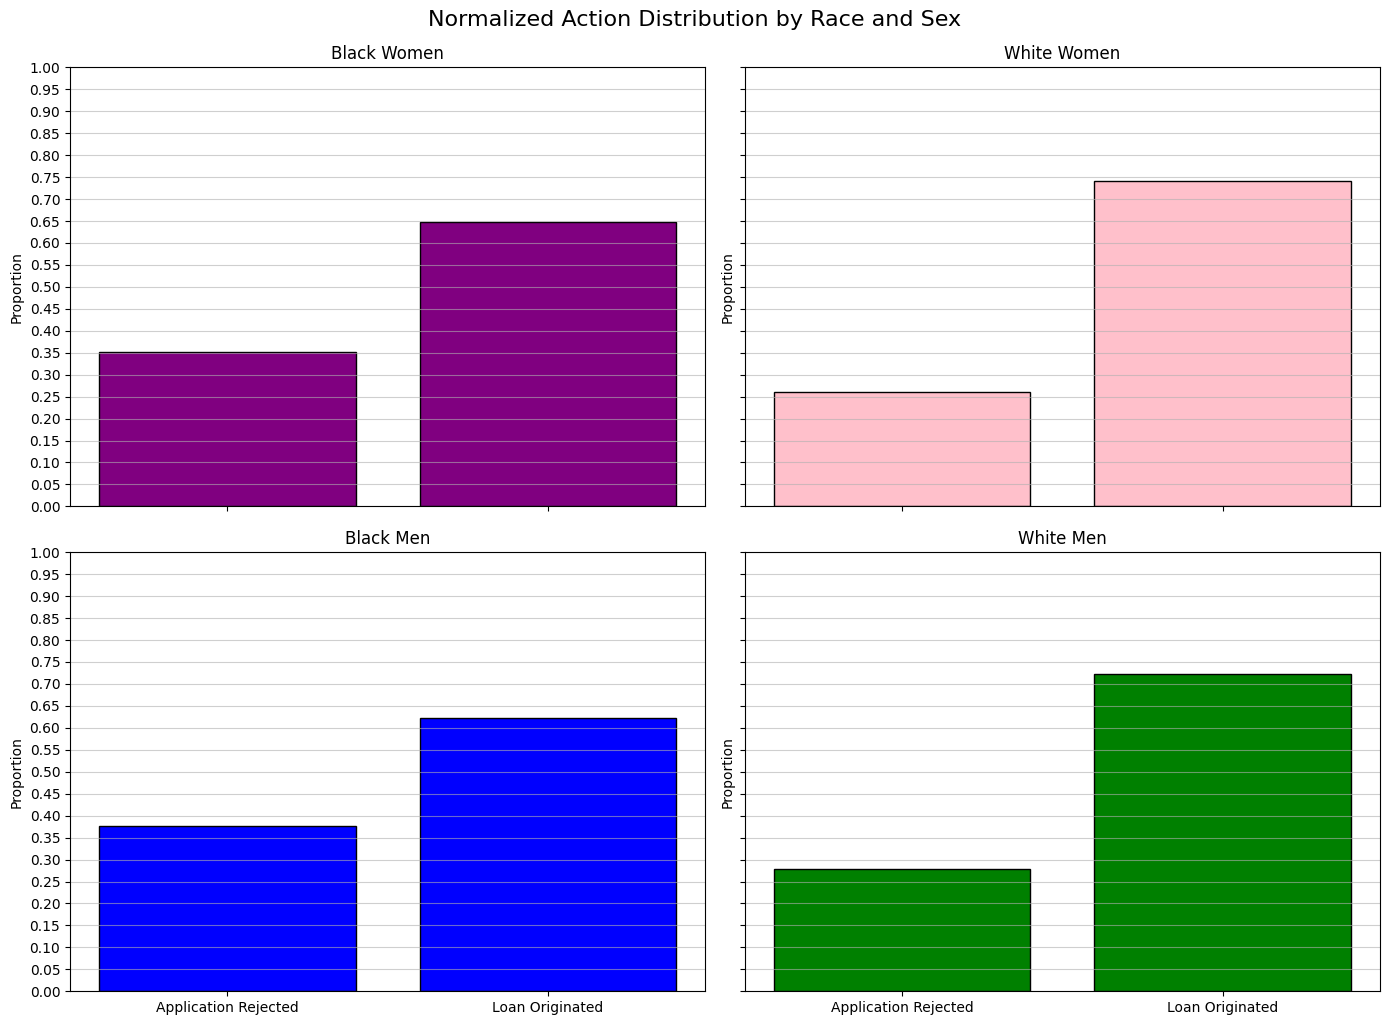

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

if research == 'income':
    # Mapping for label readability
    income_label_map = {0: '<=50K', 1: '>50K'}

    # Overall distribution
    plt.figure(figsize=(10, 6))
    income_counts = df_with_target['target'].value_counts(normalize=True).sort_index()
    income_labels = [income_label_map[i] for i in income_counts.index]
    plt.bar(income_labels, income_counts, color='skyblue', edgecolor='black')
    plt.title('Distribution of Income')
    plt.xlabel('Income')
    plt.ylabel('Proportion of Individuals')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # Subgroups
    black_women = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Female'] == 1)]
    white_women = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Female'] == 1)]
    black_men = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Male'] == 1)]
    white_men = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Male'] == 1)]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

    def plot_normalized_hist(ax, data, title, color):
        counts = data['target'].value_counts(normalize=True).sort_index()
        labels = [income_label_map.get(i, str(i)) for i in counts.index]
        ax.bar(labels, counts, color=color, edgecolor='black')
        ax.set_title(title)
        ax.set_ylim(0, 1)

    plot_normalized_hist(axes[0, 0], black_women, 'Black Women', 'purple')
    plot_normalized_hist(axes[0, 1], white_women, 'White Women', 'pink')
    plot_normalized_hist(axes[1, 0], black_men, 'Black Men', 'blue')
    plot_normalized_hist(axes[1, 1], white_men, 'White Men', 'green')

    for ax in axes.flat:
        ax.set_ylabel('Proportion')
        ax.grid(axis='y', alpha=0.6)

    plt.tight_layout()
    plt.suptitle('Normalized Income Distribution by Race and Sex', fontsize=16, y=1.02)
    plt.show()

elif research == 'loan':
    action_label_map = {1: 'Loan Originated', 0: 'Application Rejected'}

    # Demographic subsets
    black_women = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Female'] == 1)]
    white_women = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Female'] == 1)]
    black_men = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Male'] == 1)]
    white_men = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Male'] == 1)]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

    def plot_normalized_hist(ax, data, title, color):
        counts = data['target'].value_counts(normalize=True).sort_index()
        labels = [action_label_map.get(i, str(i)) for i in counts.index]
        ax.bar(labels, counts, color=color, edgecolor='black')
        ax.set_title(title)
        ax.set_ylim(0, 1)

    plot_normalized_hist(axes[0, 0], black_women, 'Black Women', 'purple')
    plot_normalized_hist(axes[0, 1], white_women, 'White Women', 'pink')
    plot_normalized_hist(axes[1, 0], black_men, 'Black Men', 'blue')
    plot_normalized_hist(axes[1, 1], white_men, 'White Men', 'green')

    for ax in axes.flat:
        ax.set_ylabel('Proportion')
        ax.grid(axis='y', alpha=0.6)
        ax.set_yticks(np.arange(0, 1.05, 0.05))

    plt.tight_layout()
    plt.suptitle('Normalized Action Distribution by Race and Sex', fontsize=16, y=1.02)
    plt.show()


Overall: 
target
Loan Originated         0.759209
Application Rejected    0.240791
Name: proportion, dtype: float64
Black Women:
target
Loan Originated         0.648267
Application Rejected    0.351733
Name: proportion, dtype: float64



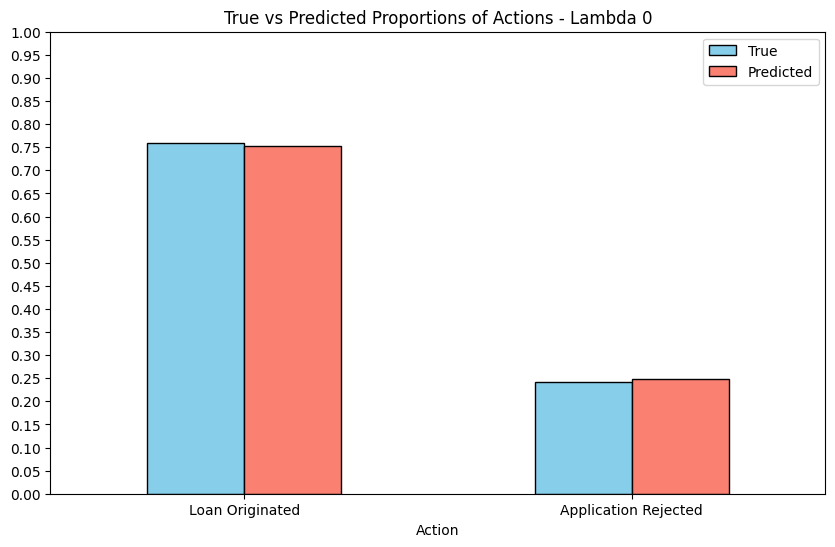

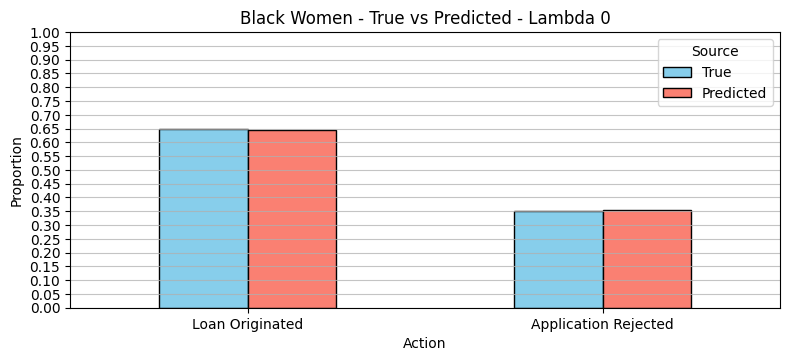

White Women:
target
Loan Originated         0.740542
Application Rejected    0.259458
Name: proportion, dtype: float64



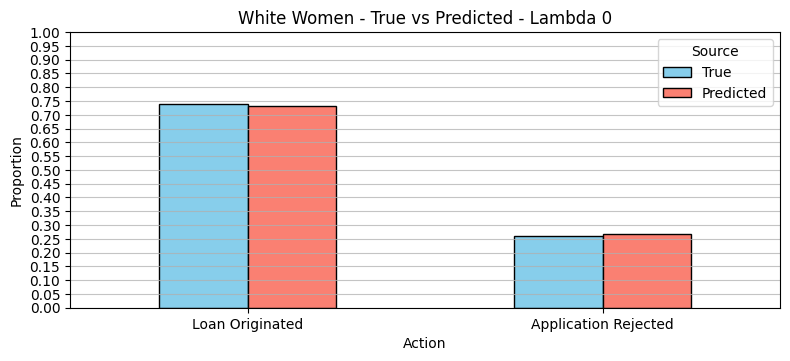

Asian Women:
target
Loan Originated         0.727686
Application Rejected    0.272314
Name: proportion, dtype: float64



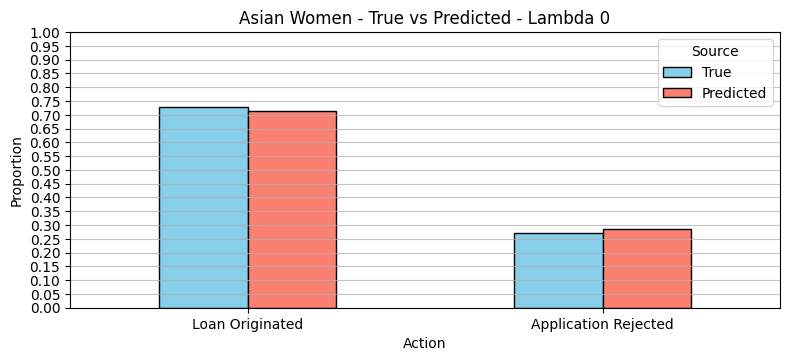

Black Men:
target
Loan Originated         0.622837
Application Rejected    0.377163
Name: proportion, dtype: float64



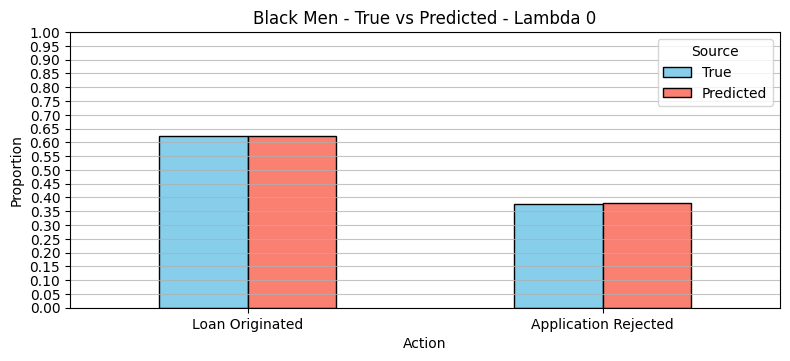

White Men:
target
Loan Originated         0.722302
Application Rejected    0.277698
Name: proportion, dtype: float64



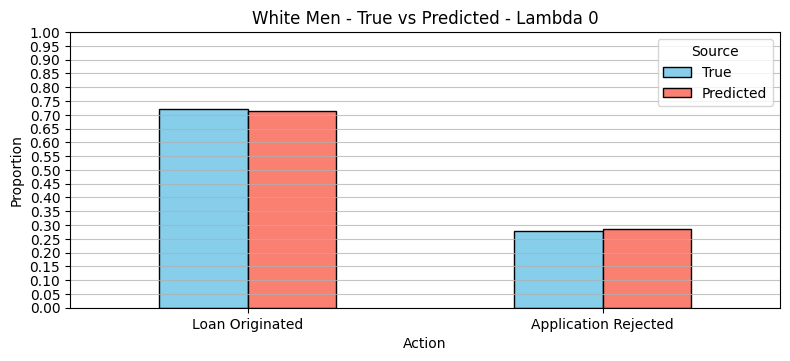

Asian Men:
target
Loan Originated         0.733085
Application Rejected    0.266915
Name: proportion, dtype: float64



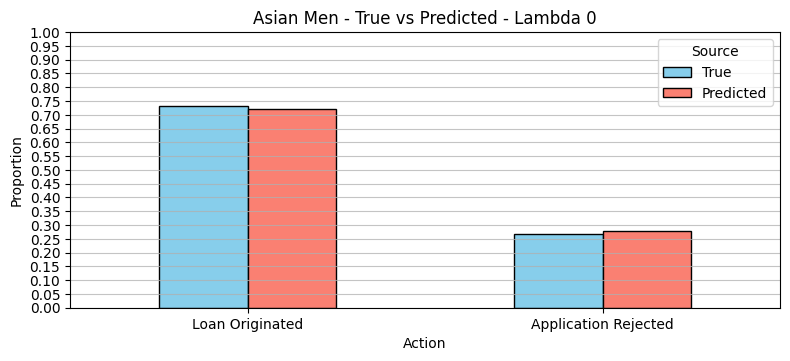

Black Joint:
target
Loan Originated         0.723206
Application Rejected    0.276794
Name: proportion, dtype: float64



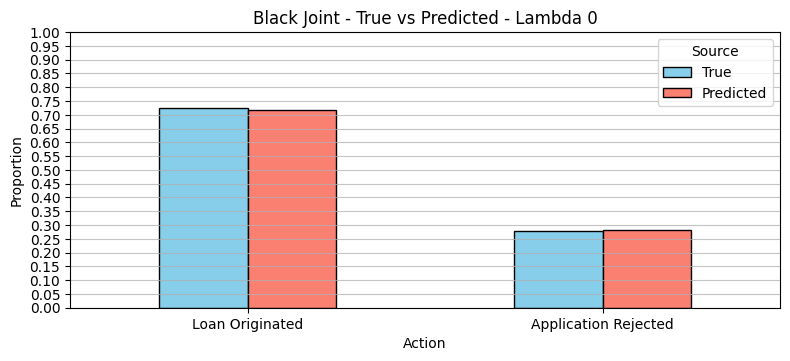

White Joint:
target
Loan Originated         0.822521
Application Rejected    0.177479
Name: proportion, dtype: float64



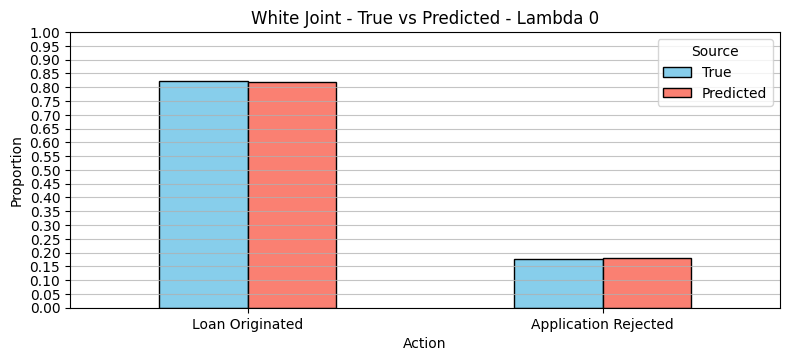

Asian Joint:
target
Loan Originated         0.815201
Application Rejected    0.184799
Name: proportion, dtype: float64



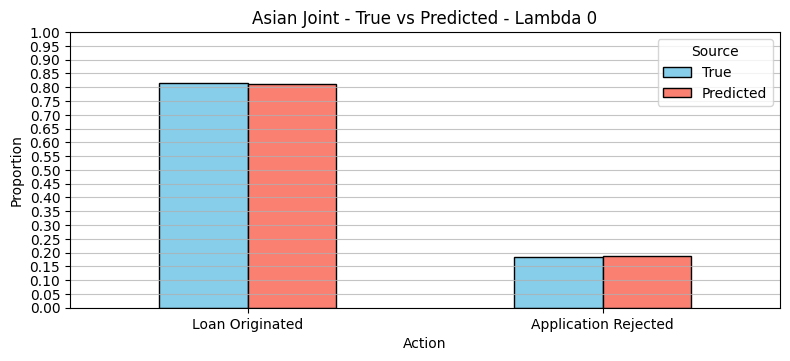

In [338]:
def evaluate_independence(path, custom_title= 0):
    model.load_state_dict(torch.load(path, weights_only=True))
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(X_tensor).numpy()
        y_pred_label = (y_pred_prob > 0.5).astype(int)
    # Flatten predicted labels
    y_pred_label_flat = y_pred_label.ravel()
    if research == 'income':
        label_map = {1: '<=50K', 0: '>50K'}
    elif research == 'loan':
        label_map = {1: 'Loan Originated', 0: 'Application Rejected'}  # adjust if needed
    true_labels = df_with_target['target'].map(label_map)
    pred_labels = pd.Series(y_pred_label_flat).map(label_map)

    # Value counts (normalized)
    true_counts = true_labels.value_counts(normalize=True)
    pred_counts = pred_labels.value_counts(normalize=True)
    print("Overall: ")
    print(true_counts)
    #print(pred_counts)
    # Combine into a DataFrame
    df_plot = pd.DataFrame({
        'True': true_counts,
        'Predicted': pred_counts
    }).fillna(0)  # Fill missing values if a class isn't predicted
    # Plot

    df_plot.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'], edgecolor='black')
    plt.yticks(np.arange(0, 1.05, 0.05))
    plt.xticks(rotation=0)
    black_women = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Female'] == 1)]
    white_women = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Female'] == 1)]
    asian_women = df_with_target[(df_with_target['race_Asian'] == 1) & (df_with_target['sex_Female'] == 1)]
    black_men = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Male'] == 1)]
    white_men = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Male'] == 1)]
    asian_men = df_with_target[(df_with_target['race_Asian'] == 1) & (df_with_target['sex_Male'] == 1)]
    black_joint = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Joint'] == 1)]
    white_joint = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Joint'] == 1)]
    asian_joint = df_with_target[(df_with_target['race_Asian'] == 1) & (df_with_target['sex_Joint'] == 1)]

    X_bw_scaled = black_women.drop(columns=['target'])
    X_ww_scaled = white_women.drop(columns=['target'])
    X_aw_scaled = asian_women.drop(columns=['target'])
    X_bm_scaled = black_men.drop(columns=['target'])
    X_wm_scaled = white_men.drop(columns=['target'])
    X_am_scaled = asian_men.drop(columns=['target'])
    X_bj_scaled = black_joint.drop(columns=['target'])  
    X_wj_scaled = white_joint.drop(columns=['target'])
    X_aj_scaled = asian_joint.drop(columns=['target'])

    X_bw_tensor = torch.tensor(X_bw_scaled.values, dtype=torch.float32).unsqueeze(1)
    X_ww_tensor = torch.tensor(X_ww_scaled.values, dtype=torch.float32).unsqueeze(1)
    X_am_tensor = torch.tensor(X_am_scaled.values, dtype=torch.float32).unsqueeze(1)
    X_bm_tensor = torch.tensor(X_bm_scaled.values, dtype=torch.float32).unsqueeze(1)
    X_wm_tensor = torch.tensor(X_wm_scaled.values, dtype=torch.float32).unsqueeze(1)
    X_aw_tensor = torch.tensor(X_aw_scaled.values, dtype=torch.float32).unsqueeze(1)
    X_bj_tensor = torch.tensor(X_bj_scaled.values, dtype=torch.float32).unsqueeze(1)
    X_wj_tensor = torch.tensor(X_wj_scaled.values, dtype=torch.float32).unsqueeze(1)
    X_aj_tensor = torch.tensor(X_aj_scaled.values, dtype=torch.float32).unsqueeze(1)

    
    groups = {
        "Black Women": (black_women, X_bw_tensor),
        "White Women": (white_women, X_ww_tensor),
        "Asian Women": (asian_women, X_aw_tensor),
        "Black Men": (black_men, X_bm_tensor),
        "White Men": (white_men, X_wm_tensor),
        "Asian Men": (asian_men, X_am_tensor),
        "Black Joint": (black_joint, X_bj_tensor),
        "White Joint": (white_joint, X_wj_tensor),
        "Asian Joint": (asian_joint, X_aj_tensor),
    }

    if research == 'income':
        plt.title('True vs Predicted Proportions of Actions')
        plt.xlabel('Action')

    elif research == 'loan':
        plt.title(f'True vs Predicted Proportions of Actions - Lambda {custom_title}')
        plt.xlabel('Action')

    for group_name, (group_df, group_X_tensor) in groups.items():
        with torch.no_grad():
            y_pred_prob = model(group_X_tensor).numpy()
            y_pred_label = (y_pred_prob > 0.5).astype(int).ravel()

        # Map labels to strings
        true_labels = group_df['target'].map(label_map)
        pred_labels = pd.Series(y_pred_label).map(label_map)

        # Value counts (normalized)
        true_counts = true_labels.value_counts(normalize=True)
        pred_counts = pred_labels.value_counts(normalize=True)
        print(f'{group_name}:')
        print(true_counts)
        #print(pred_counts)
        print()
        # Combine into DataFrame
        df_plot = pd.DataFrame({
            'True': true_counts,
            'Predicted': pred_counts
        }).fillna(0)

        # Plot
        ax = df_plot.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'], edgecolor='black')
        plt.title(f'{group_name} - True vs Predicted - Lambda {custom_title}')
        plt.ylabel('Proportion')
        if research == 'income':
            plt.xlabel('Action')

        elif research == 'loan':
            plt.xlabel('Action')
        plt.ylim(0, 1)
        plt.yticks(np.arange(0, 1.05, 0.05))
        plt.grid(axis='y', alpha=0.75)
        plt.legend(title='Source')
        plt.tight_layout()
        plt.ylabel('Proportion')
        plt.xticks(rotation=0)
        plt.show()
model_save_filepath = f'mlp_models_unscaled/baselineCNN_{research}'
evaluate_independence(model_save_filepath)

Overall: 
target
Loan Originated         0.759209
Application Rejected    0.240791
Name: proportion, dtype: float64
Black Women:
target
Loan Originated         0.648267
Application Rejected    0.351733
Name: proportion, dtype: float64



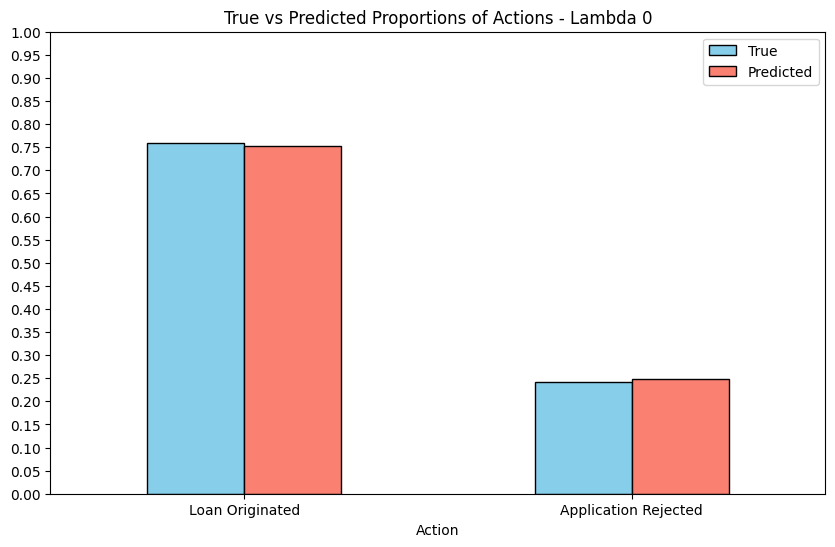

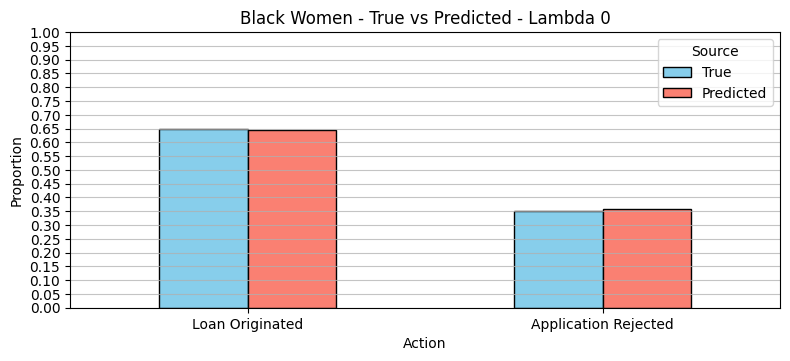

White Women:
target
Loan Originated         0.740542
Application Rejected    0.259458
Name: proportion, dtype: float64



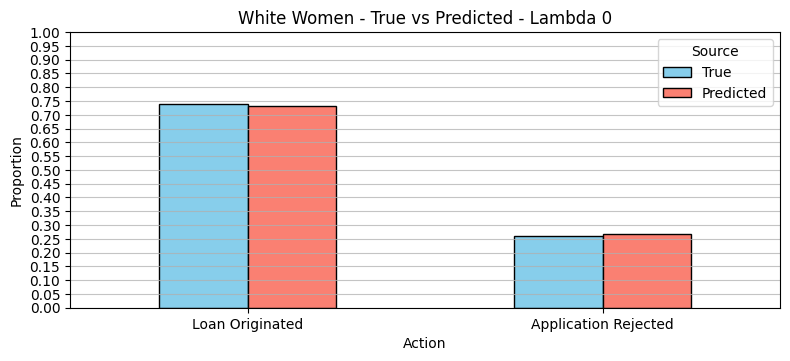

Asian Women:
target
Loan Originated         0.727686
Application Rejected    0.272314
Name: proportion, dtype: float64



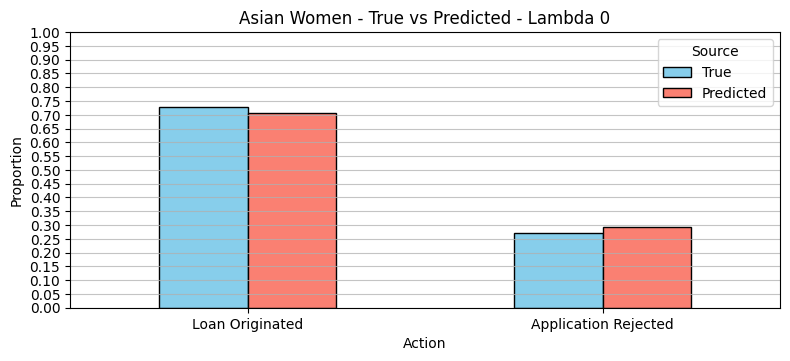

Black Men:
target
Loan Originated         0.622837
Application Rejected    0.377163
Name: proportion, dtype: float64



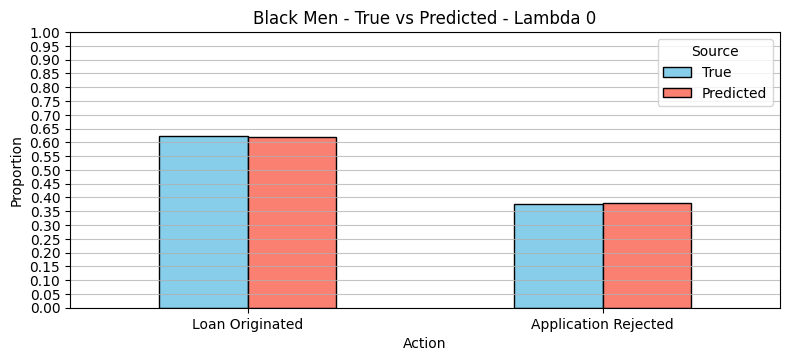

White Men:
target
Loan Originated         0.722302
Application Rejected    0.277698
Name: proportion, dtype: float64



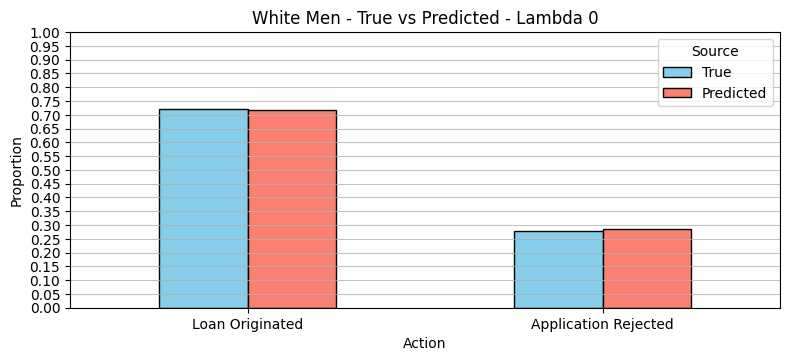

Asian Men:
target
Loan Originated         0.733085
Application Rejected    0.266915
Name: proportion, dtype: float64



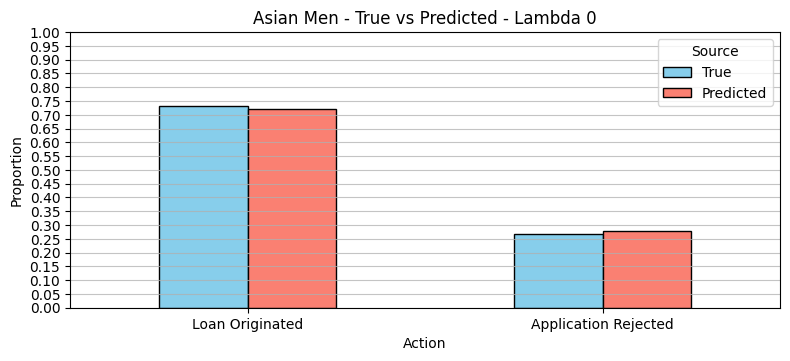

Black Joint:
target
Loan Originated         0.723206
Application Rejected    0.276794
Name: proportion, dtype: float64



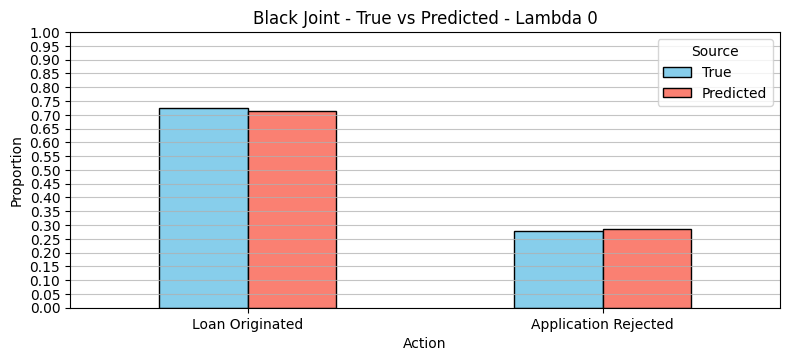

White Joint:
target
Loan Originated         0.822521
Application Rejected    0.177479
Name: proportion, dtype: float64



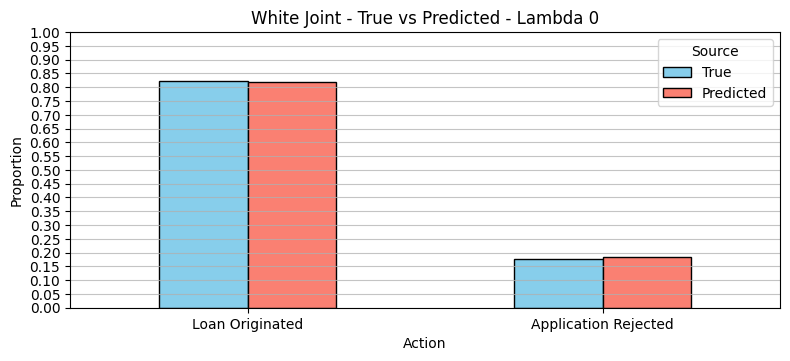

Asian Joint:
target
Loan Originated         0.815201
Application Rejected    0.184799
Name: proportion, dtype: float64



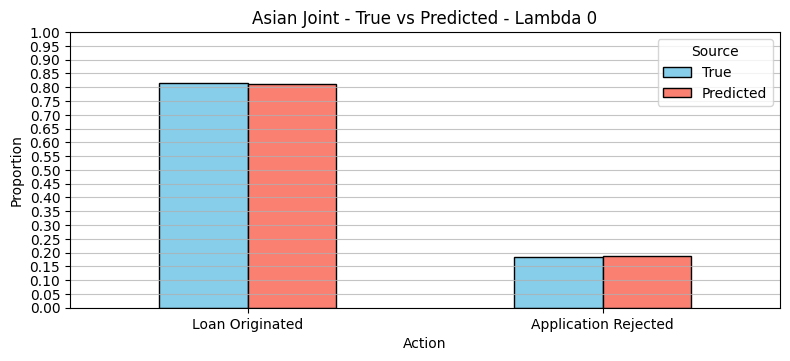

Overall: 
target
Loan Originated         0.759209
Application Rejected    0.240791
Name: proportion, dtype: float64
Black Women:
target
Loan Originated         0.648267
Application Rejected    0.351733
Name: proportion, dtype: float64



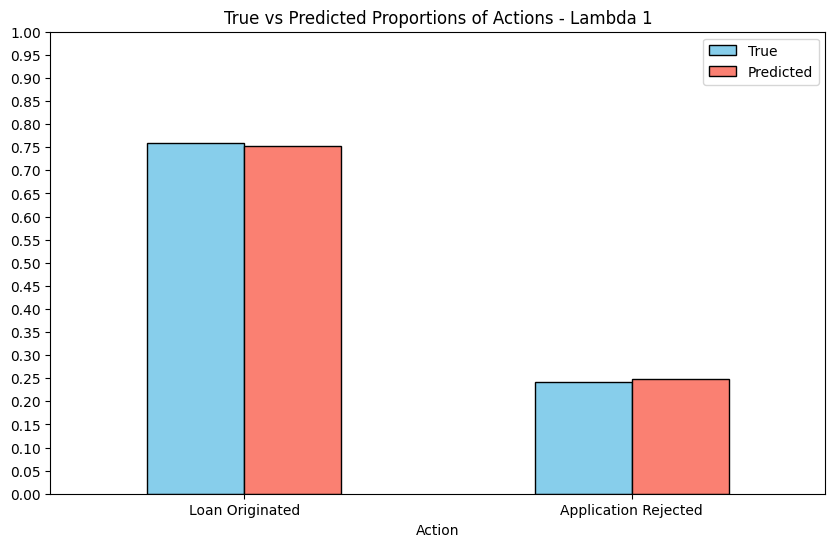

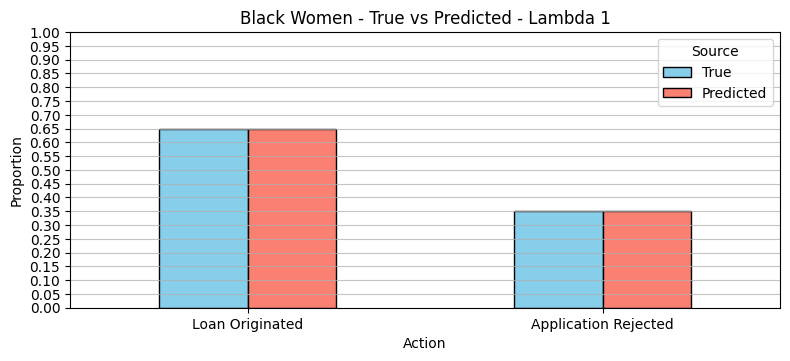

White Women:
target
Loan Originated         0.740542
Application Rejected    0.259458
Name: proportion, dtype: float64



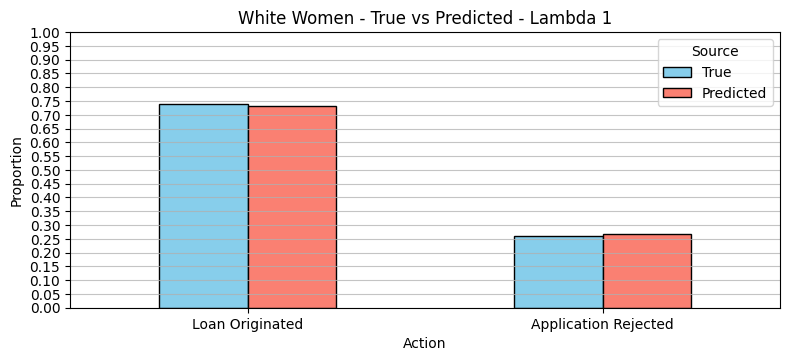

Asian Women:
target
Loan Originated         0.727686
Application Rejected    0.272314
Name: proportion, dtype: float64



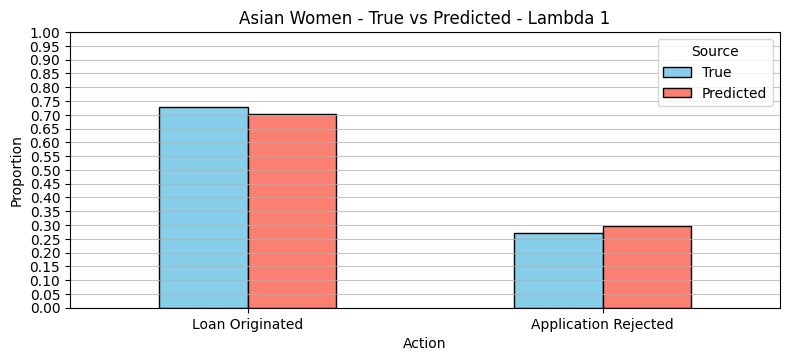

Black Men:
target
Loan Originated         0.622837
Application Rejected    0.377163
Name: proportion, dtype: float64



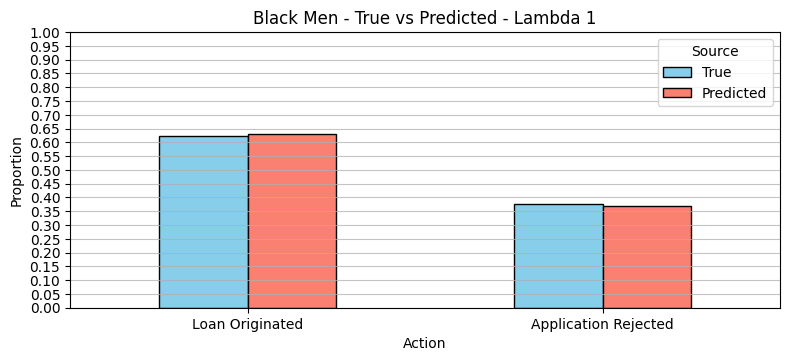

White Men:
target
Loan Originated         0.722302
Application Rejected    0.277698
Name: proportion, dtype: float64



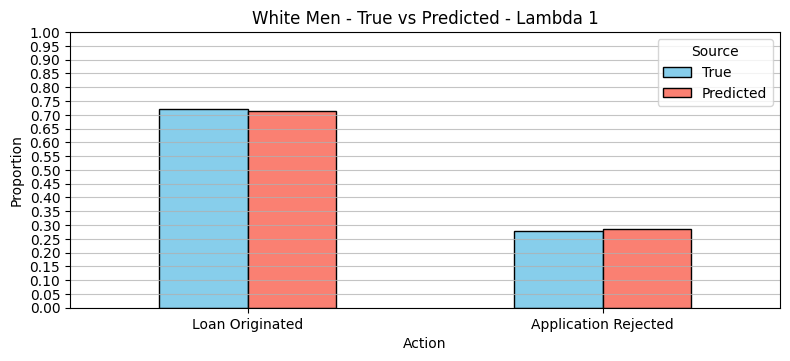

Asian Men:
target
Loan Originated         0.733085
Application Rejected    0.266915
Name: proportion, dtype: float64



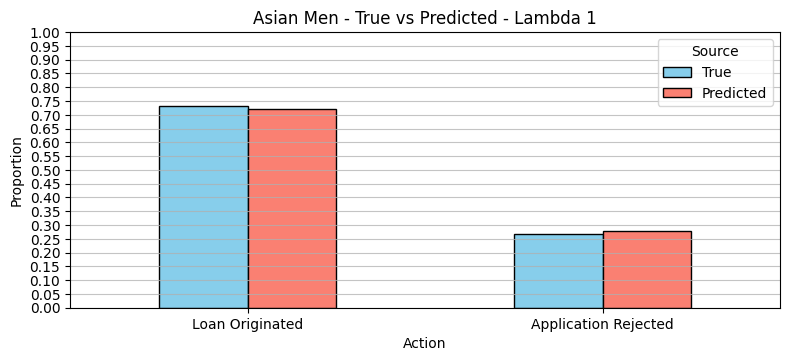

Black Joint:
target
Loan Originated         0.723206
Application Rejected    0.276794
Name: proportion, dtype: float64



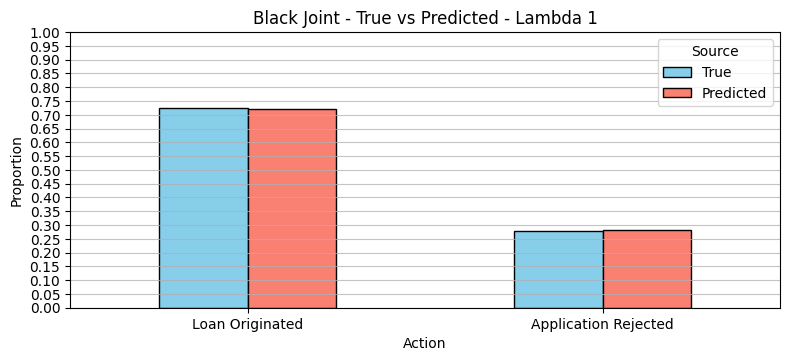

White Joint:
target
Loan Originated         0.822521
Application Rejected    0.177479
Name: proportion, dtype: float64



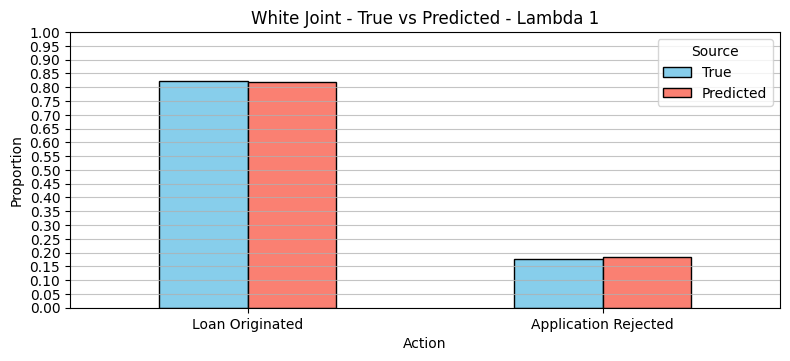

Asian Joint:
target
Loan Originated         0.815201
Application Rejected    0.184799
Name: proportion, dtype: float64



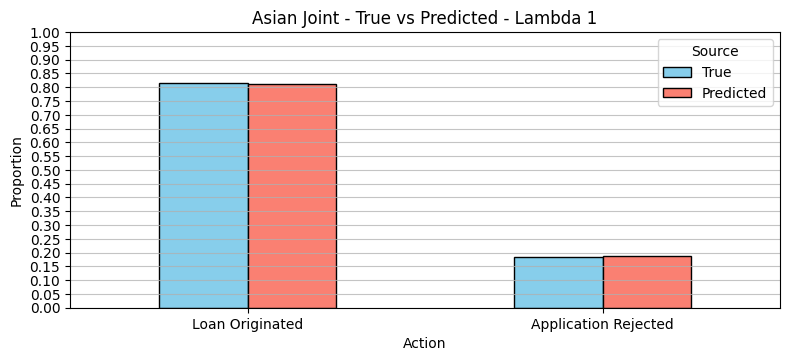

Overall: 
target
Loan Originated         0.759209
Application Rejected    0.240791
Name: proportion, dtype: float64
Black Women:
target
Loan Originated         0.648267
Application Rejected    0.351733
Name: proportion, dtype: float64



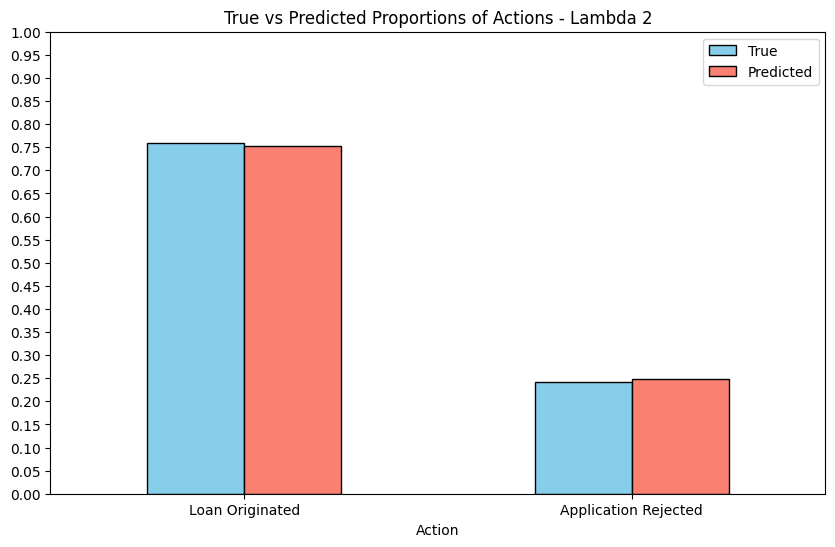

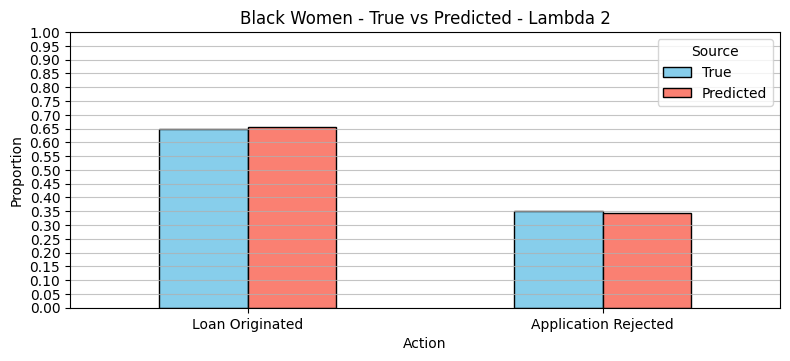

White Women:
target
Loan Originated         0.740542
Application Rejected    0.259458
Name: proportion, dtype: float64



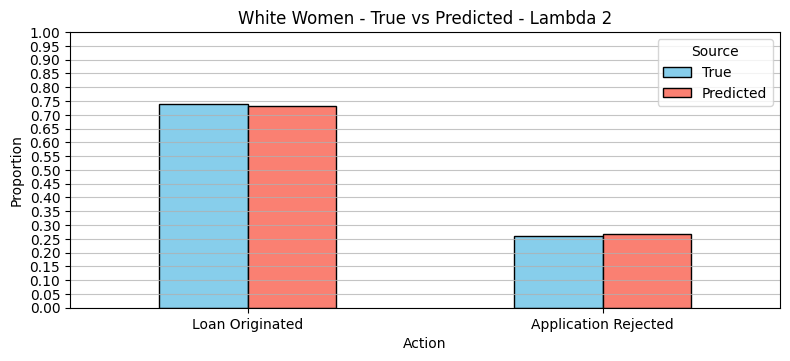

Asian Women:
target
Loan Originated         0.727686
Application Rejected    0.272314
Name: proportion, dtype: float64



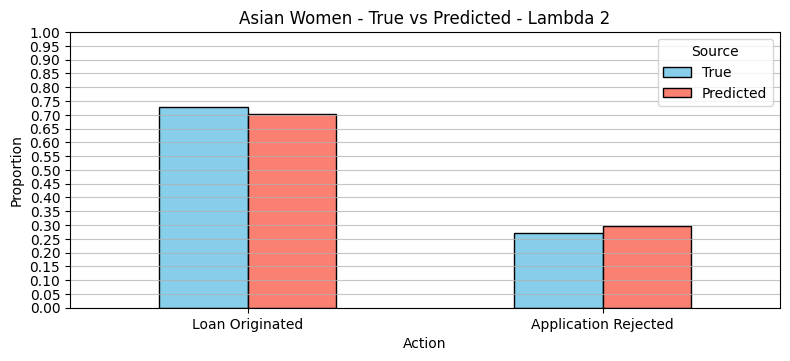

Black Men:
target
Loan Originated         0.622837
Application Rejected    0.377163
Name: proportion, dtype: float64



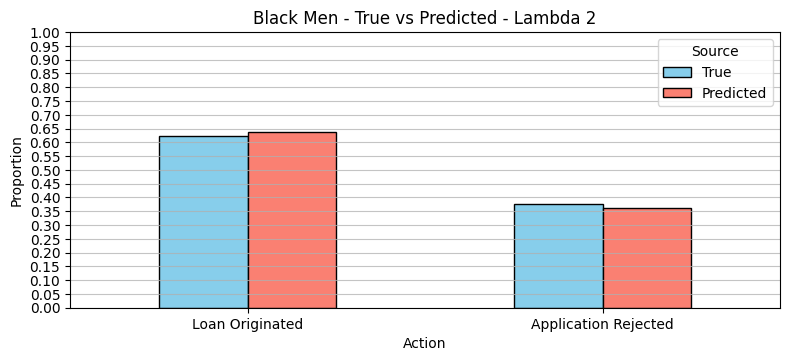

White Men:
target
Loan Originated         0.722302
Application Rejected    0.277698
Name: proportion, dtype: float64



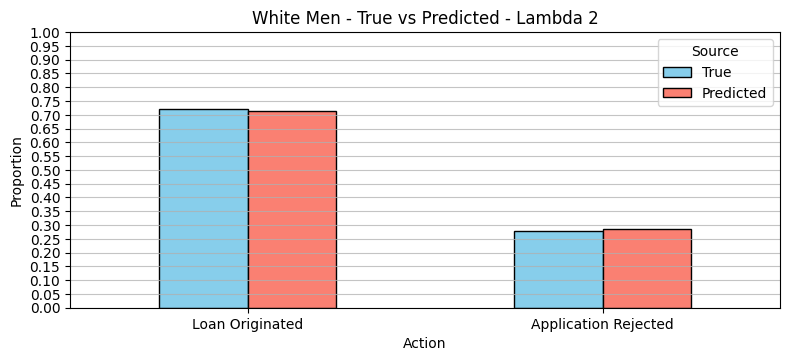

Asian Men:
target
Loan Originated         0.733085
Application Rejected    0.266915
Name: proportion, dtype: float64



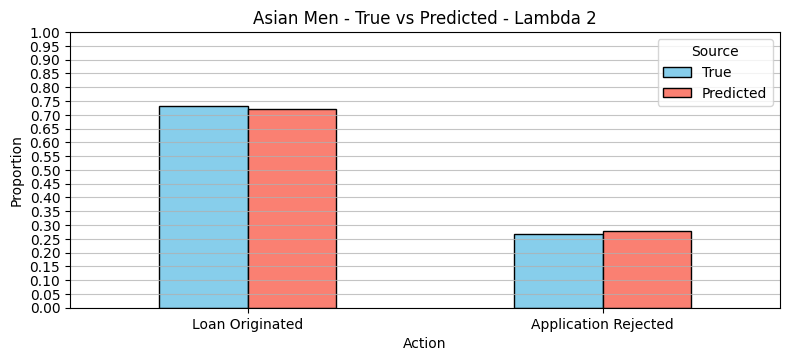

Black Joint:
target
Loan Originated         0.723206
Application Rejected    0.276794
Name: proportion, dtype: float64



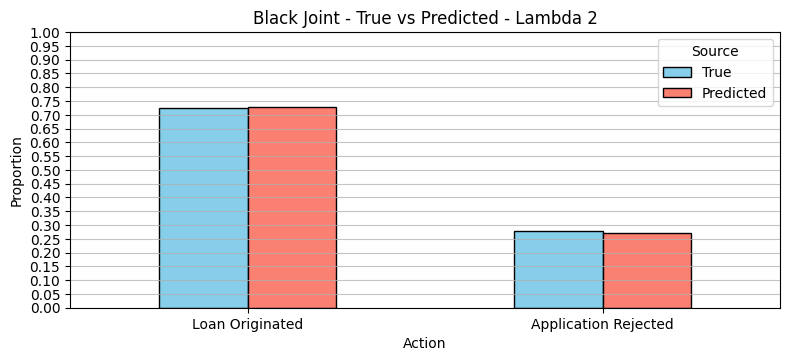

White Joint:
target
Loan Originated         0.822521
Application Rejected    0.177479
Name: proportion, dtype: float64



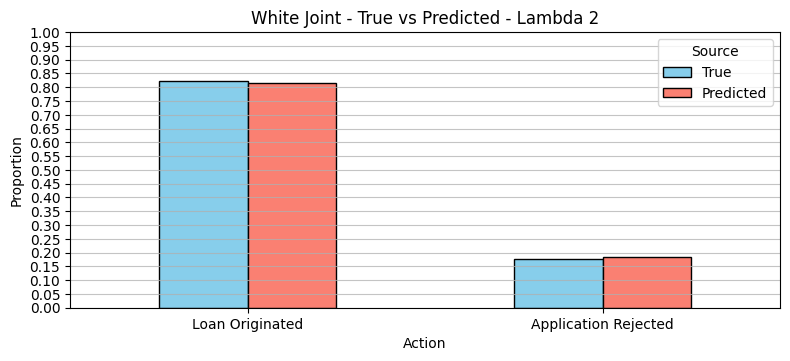

Asian Joint:
target
Loan Originated         0.815201
Application Rejected    0.184799
Name: proportion, dtype: float64



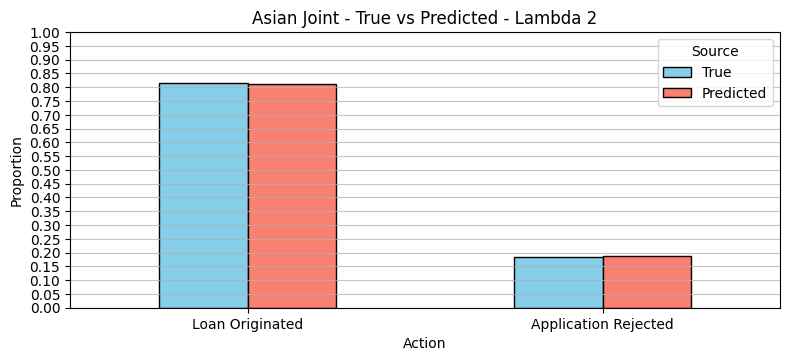

Overall: 
target
Loan Originated         0.759209
Application Rejected    0.240791
Name: proportion, dtype: float64
Black Women:
target
Loan Originated         0.648267
Application Rejected    0.351733
Name: proportion, dtype: float64



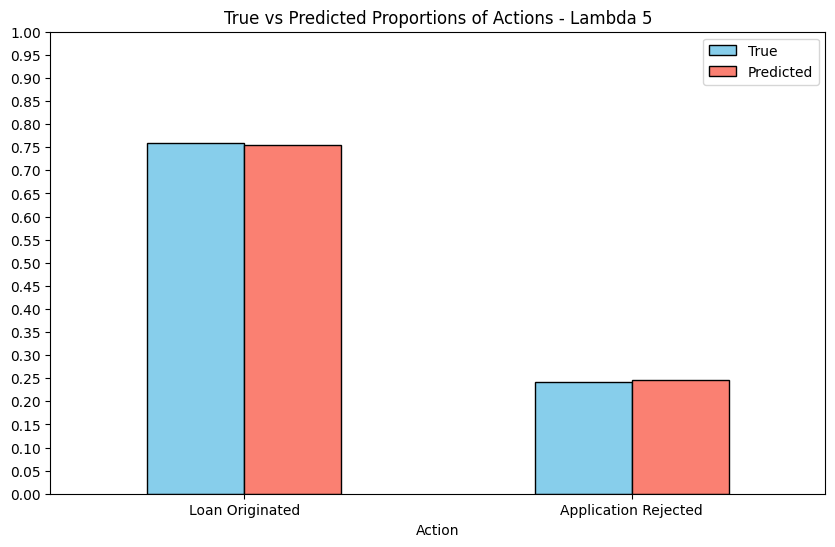

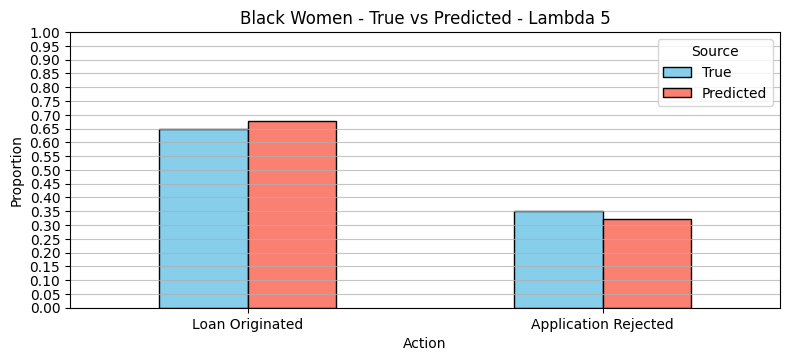

White Women:
target
Loan Originated         0.740542
Application Rejected    0.259458
Name: proportion, dtype: float64



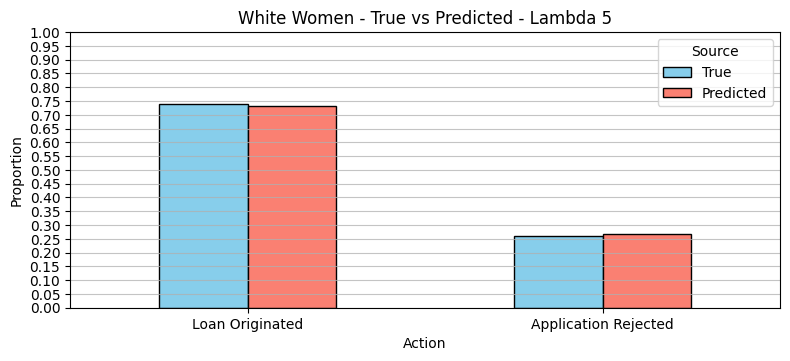

Asian Women:
target
Loan Originated         0.727686
Application Rejected    0.272314
Name: proportion, dtype: float64



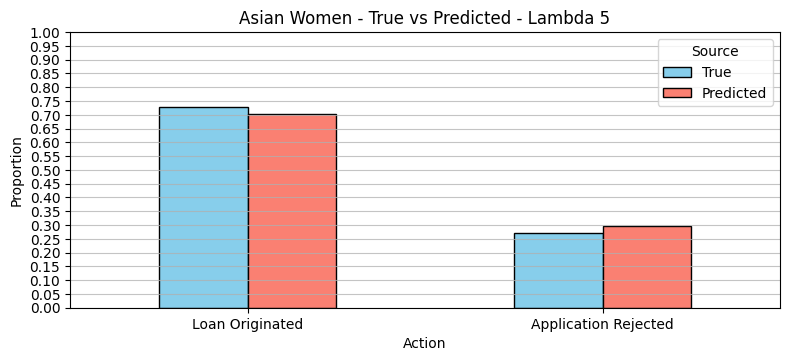

Black Men:
target
Loan Originated         0.622837
Application Rejected    0.377163
Name: proportion, dtype: float64



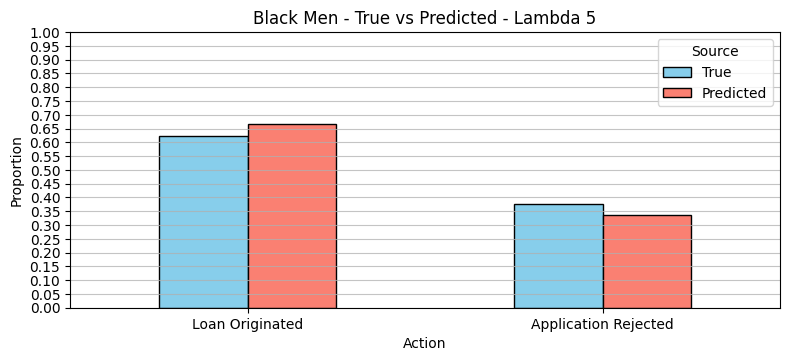

White Men:
target
Loan Originated         0.722302
Application Rejected    0.277698
Name: proportion, dtype: float64



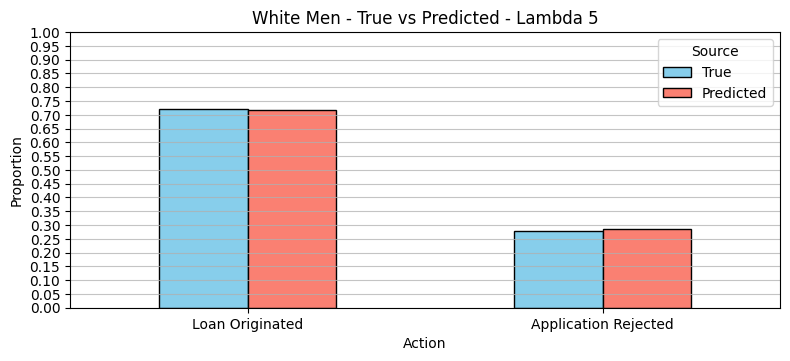

Asian Men:
target
Loan Originated         0.733085
Application Rejected    0.266915
Name: proportion, dtype: float64



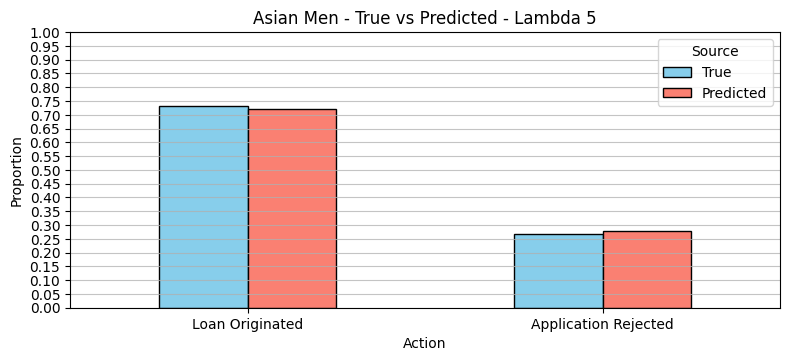

Black Joint:
target
Loan Originated         0.723206
Application Rejected    0.276794
Name: proportion, dtype: float64



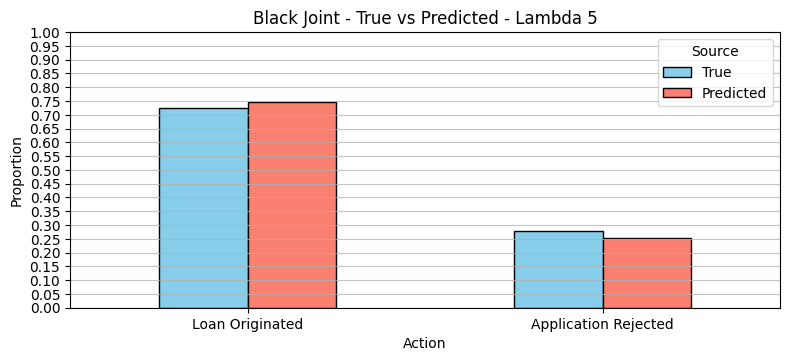

White Joint:
target
Loan Originated         0.822521
Application Rejected    0.177479
Name: proportion, dtype: float64



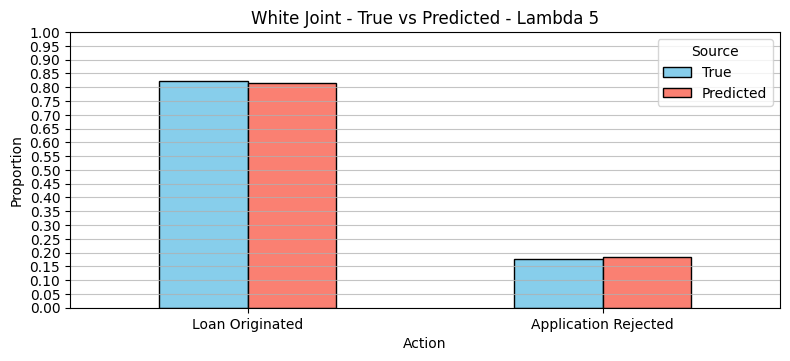

Asian Joint:
target
Loan Originated         0.815201
Application Rejected    0.184799
Name: proportion, dtype: float64



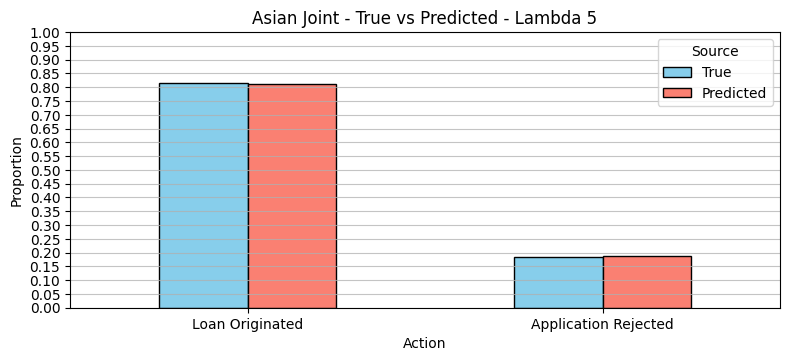

Overall: 
target
Loan Originated         0.759209
Application Rejected    0.240791
Name: proportion, dtype: float64
Black Women:
target
Loan Originated         0.648267
Application Rejected    0.351733
Name: proportion, dtype: float64



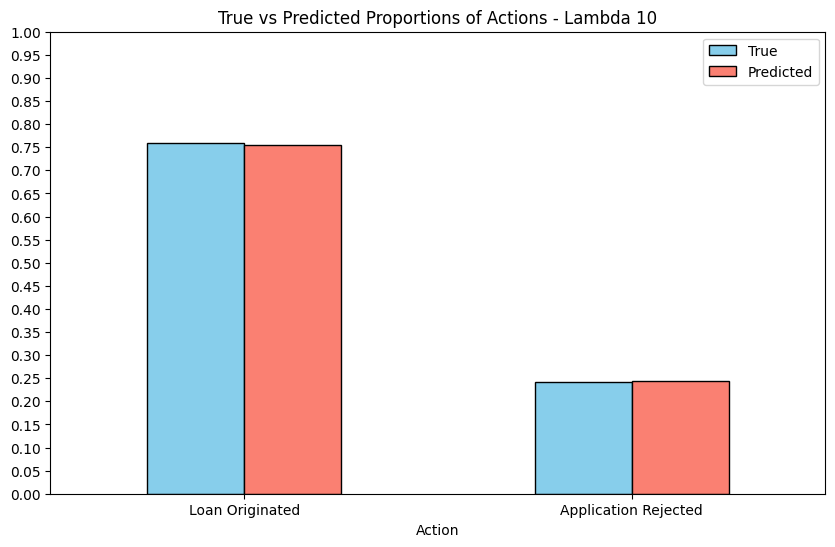

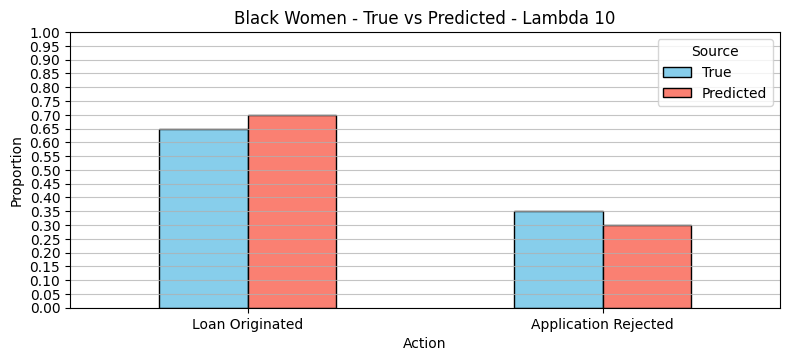

White Women:
target
Loan Originated         0.740542
Application Rejected    0.259458
Name: proportion, dtype: float64



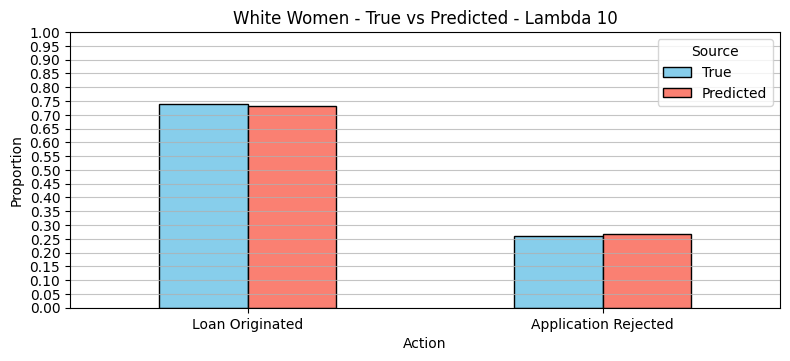

Asian Women:
target
Loan Originated         0.727686
Application Rejected    0.272314
Name: proportion, dtype: float64



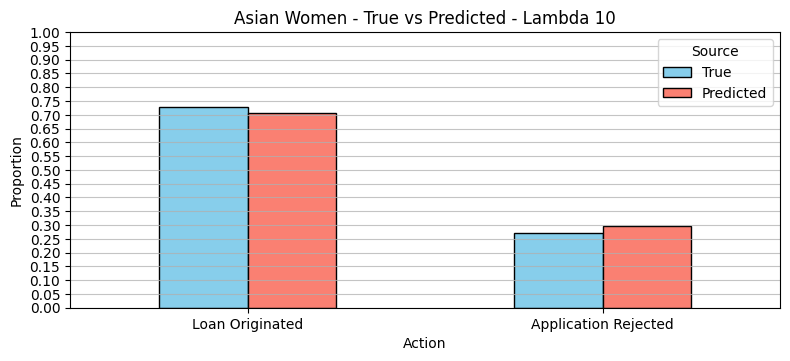

Black Men:
target
Loan Originated         0.622837
Application Rejected    0.377163
Name: proportion, dtype: float64



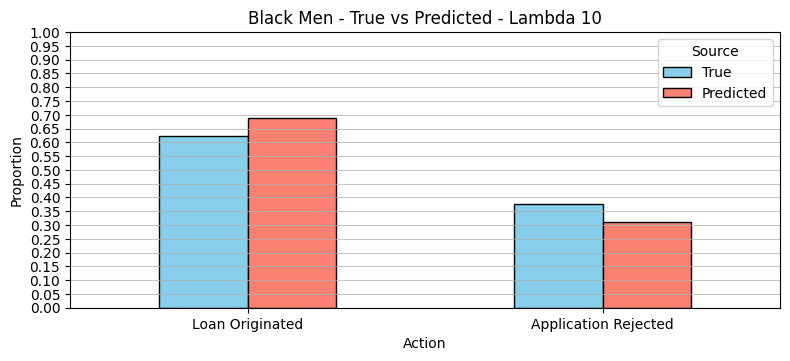

White Men:
target
Loan Originated         0.722302
Application Rejected    0.277698
Name: proportion, dtype: float64



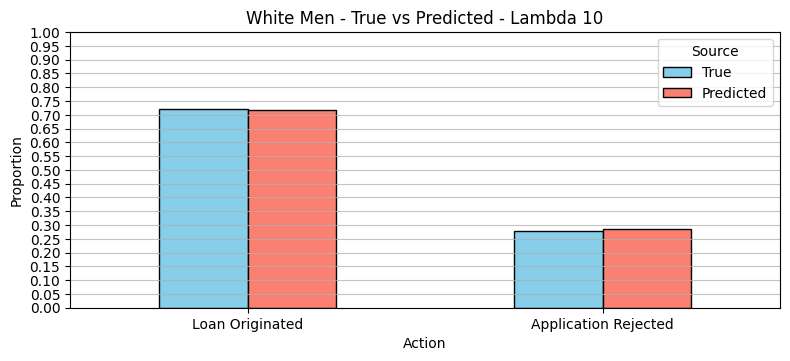

Asian Men:
target
Loan Originated         0.733085
Application Rejected    0.266915
Name: proportion, dtype: float64



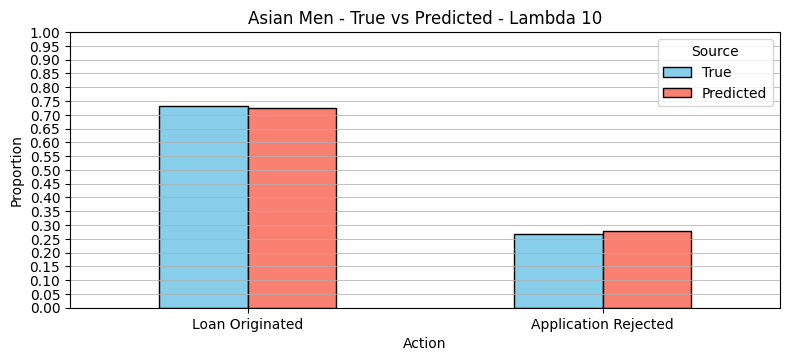

Black Joint:
target
Loan Originated         0.723206
Application Rejected    0.276794
Name: proportion, dtype: float64



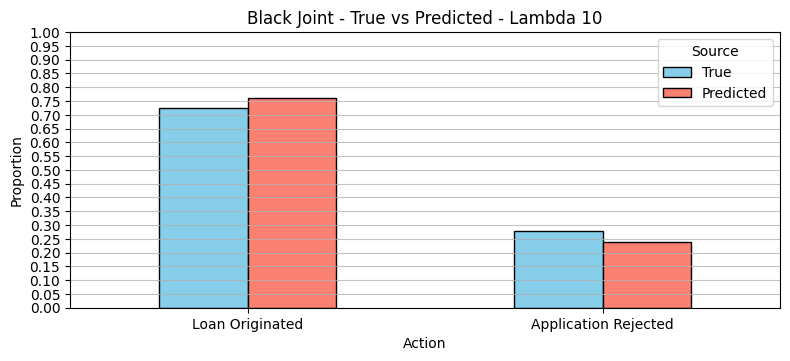

White Joint:
target
Loan Originated         0.822521
Application Rejected    0.177479
Name: proportion, dtype: float64



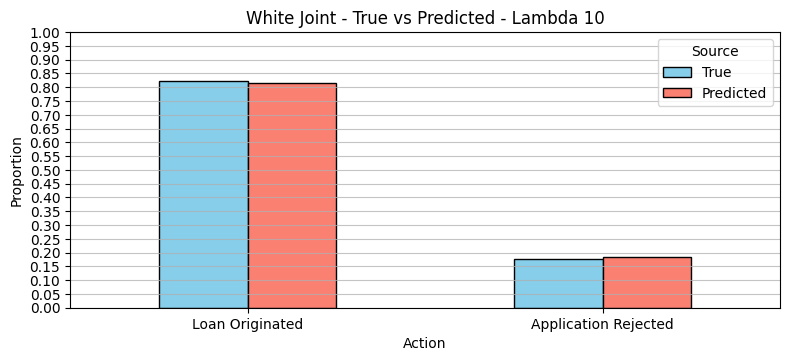

Asian Joint:
target
Loan Originated         0.815201
Application Rejected    0.184799
Name: proportion, dtype: float64



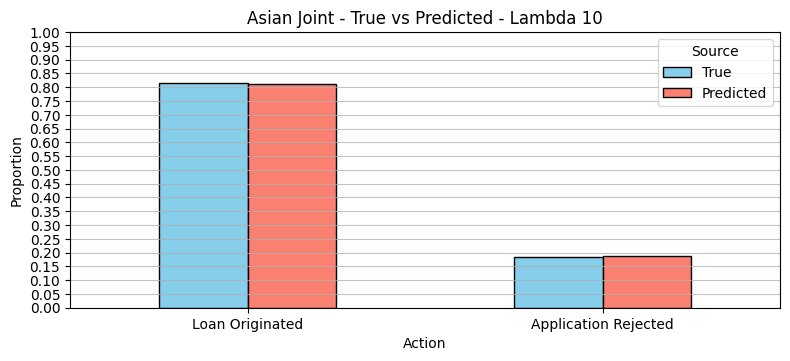

Overall: 
target
Loan Originated         0.759209
Application Rejected    0.240791
Name: proportion, dtype: float64
Black Women:
target
Loan Originated         0.648267
Application Rejected    0.351733
Name: proportion, dtype: float64



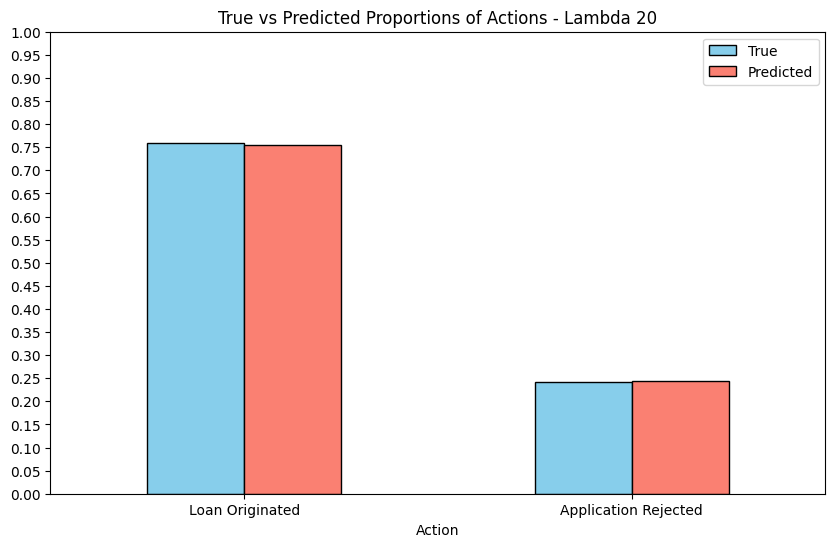

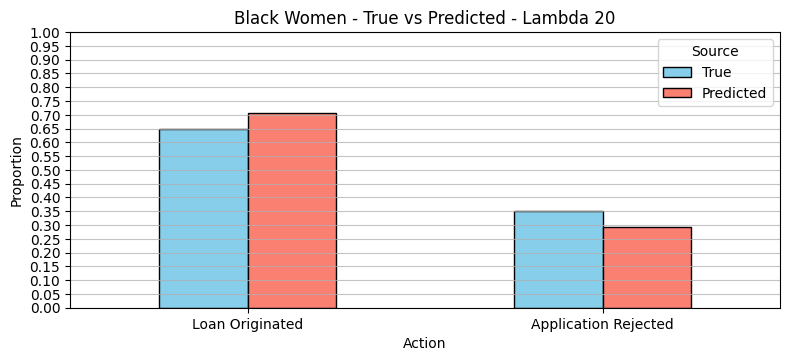

White Women:
target
Loan Originated         0.740542
Application Rejected    0.259458
Name: proportion, dtype: float64



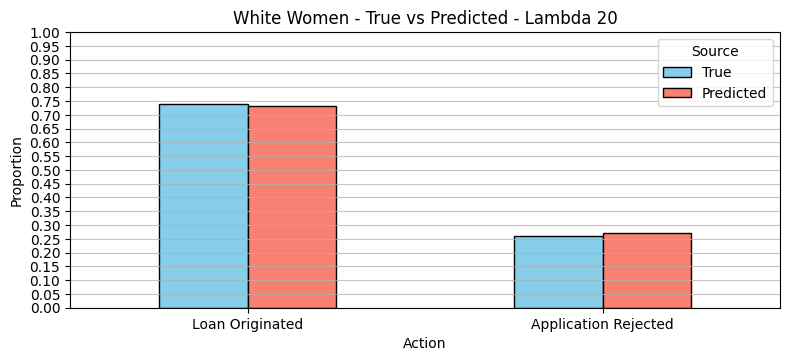

Asian Women:
target
Loan Originated         0.727686
Application Rejected    0.272314
Name: proportion, dtype: float64



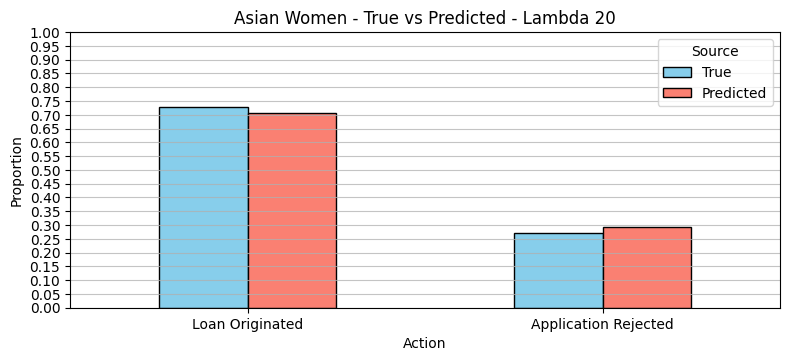

Black Men:
target
Loan Originated         0.622837
Application Rejected    0.377163
Name: proportion, dtype: float64



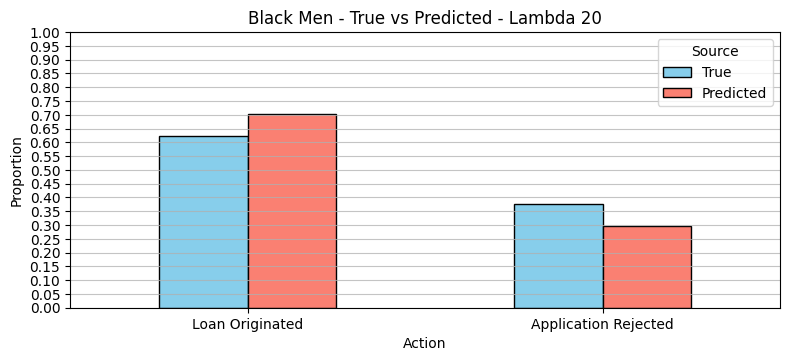

White Men:
target
Loan Originated         0.722302
Application Rejected    0.277698
Name: proportion, dtype: float64



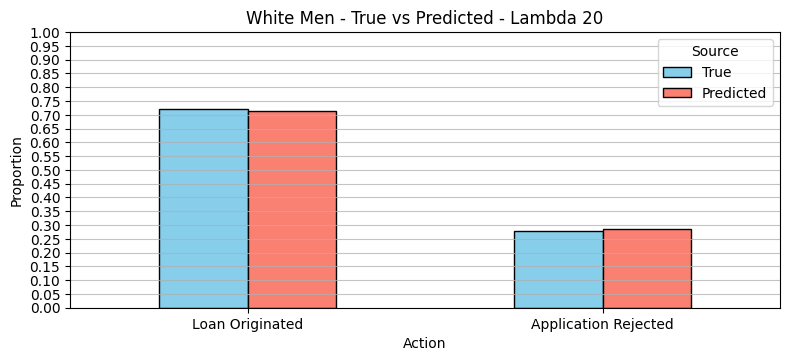

Asian Men:
target
Loan Originated         0.733085
Application Rejected    0.266915
Name: proportion, dtype: float64



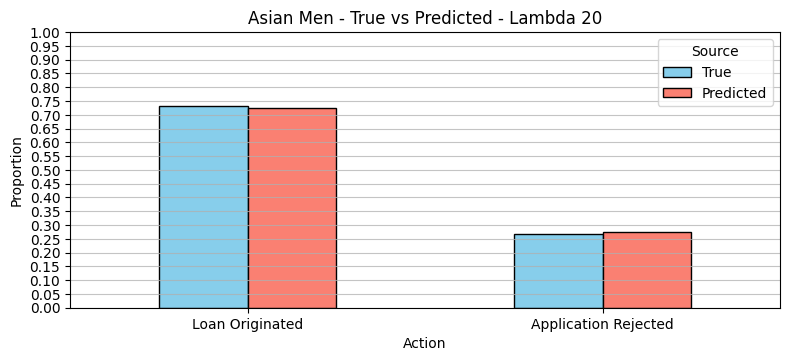

Black Joint:
target
Loan Originated         0.723206
Application Rejected    0.276794
Name: proportion, dtype: float64



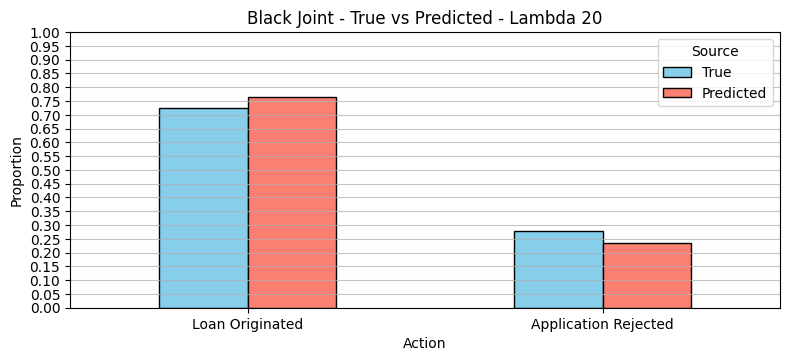

White Joint:
target
Loan Originated         0.822521
Application Rejected    0.177479
Name: proportion, dtype: float64



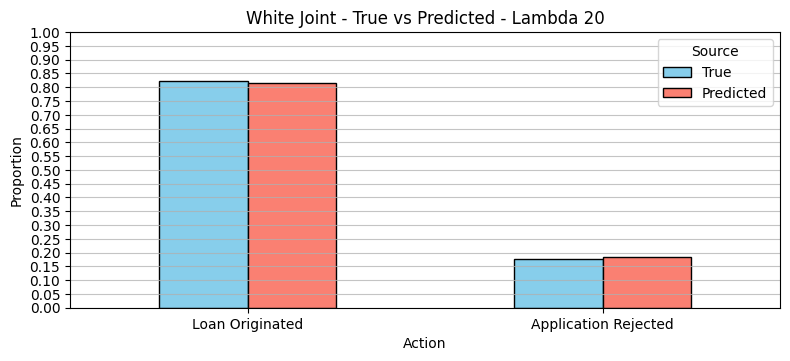

Asian Joint:
target
Loan Originated         0.815201
Application Rejected    0.184799
Name: proportion, dtype: float64



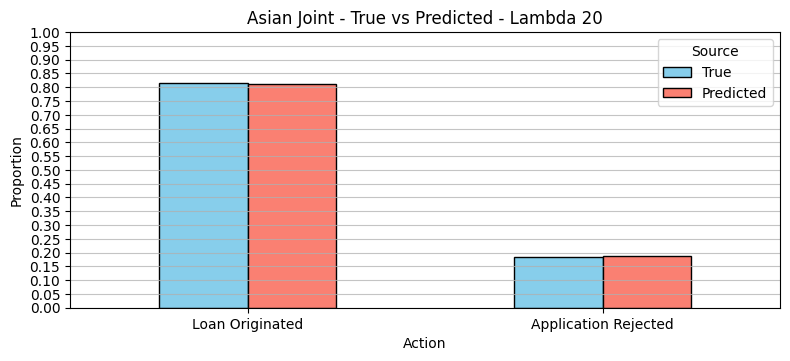

Overall: 
target
Loan Originated         0.759209
Application Rejected    0.240791
Name: proportion, dtype: float64
Black Women:
target
Loan Originated         0.648267
Application Rejected    0.351733
Name: proportion, dtype: float64



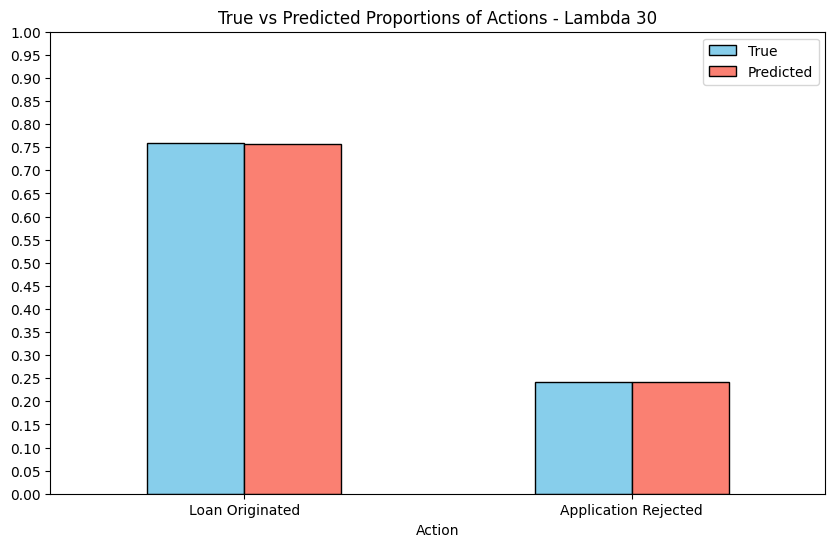

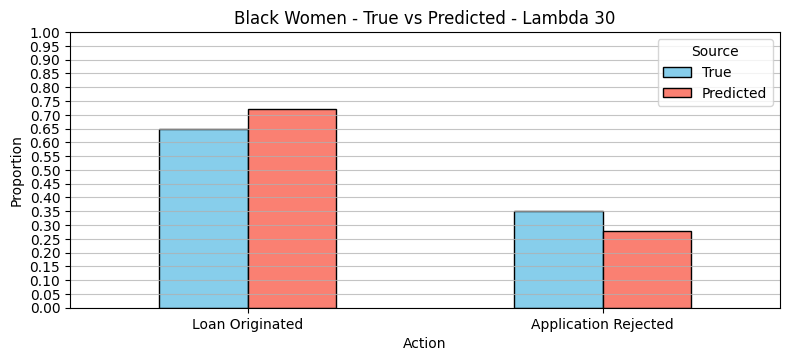

White Women:
target
Loan Originated         0.740542
Application Rejected    0.259458
Name: proportion, dtype: float64



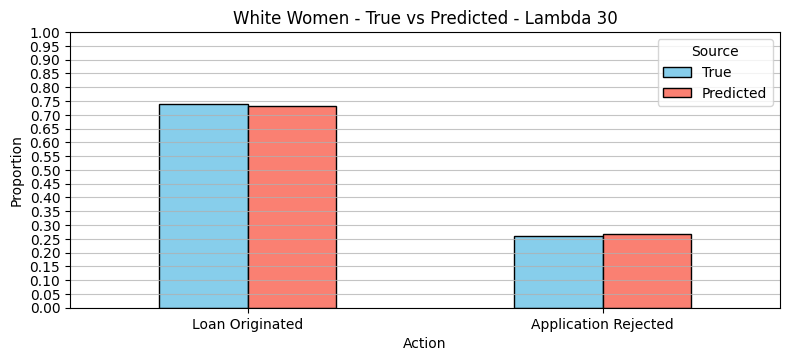

Asian Women:
target
Loan Originated         0.727686
Application Rejected    0.272314
Name: proportion, dtype: float64



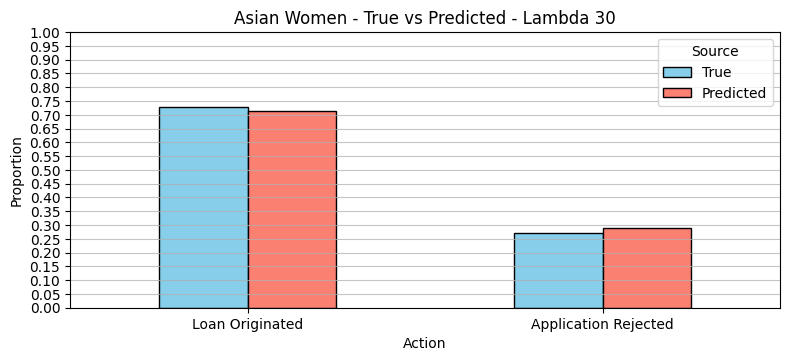

Black Men:
target
Loan Originated         0.622837
Application Rejected    0.377163
Name: proportion, dtype: float64



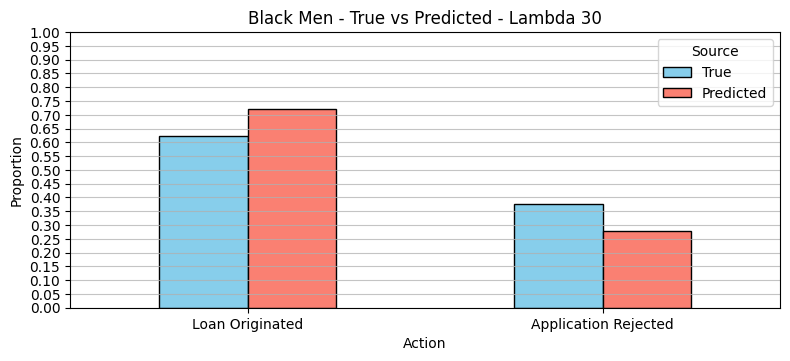

White Men:
target
Loan Originated         0.722302
Application Rejected    0.277698
Name: proportion, dtype: float64



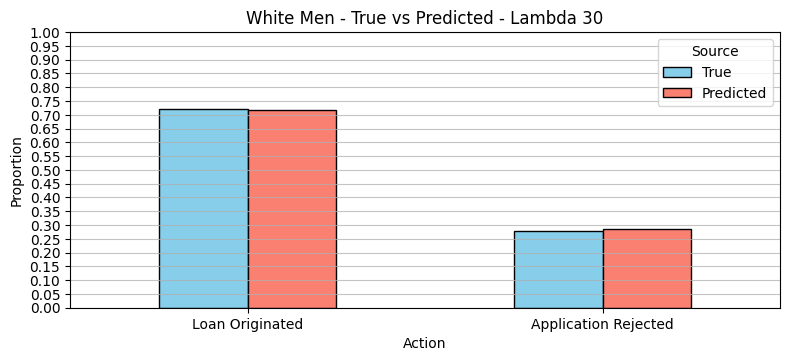

Asian Men:
target
Loan Originated         0.733085
Application Rejected    0.266915
Name: proportion, dtype: float64



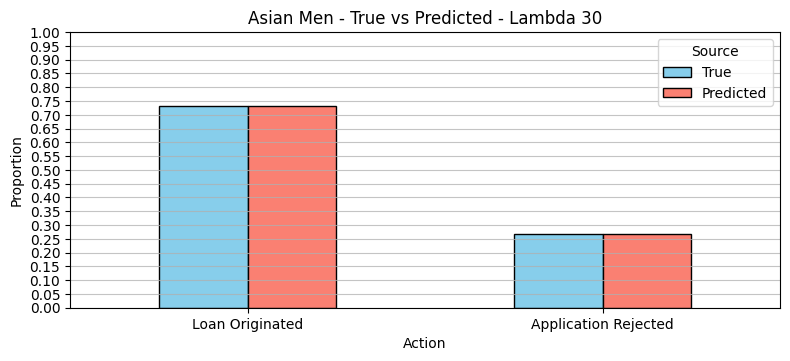

Black Joint:
target
Loan Originated         0.723206
Application Rejected    0.276794
Name: proportion, dtype: float64



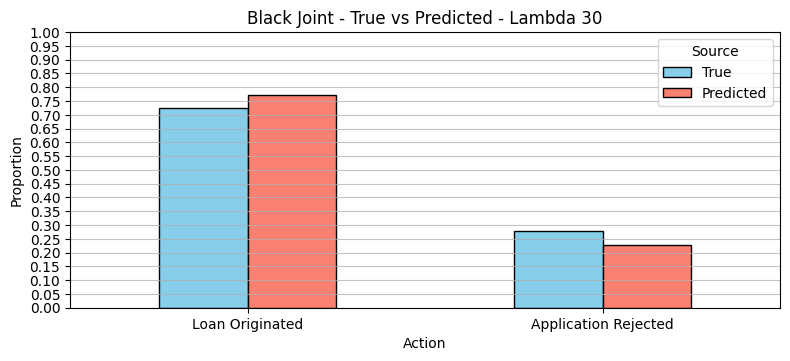

White Joint:
target
Loan Originated         0.822521
Application Rejected    0.177479
Name: proportion, dtype: float64



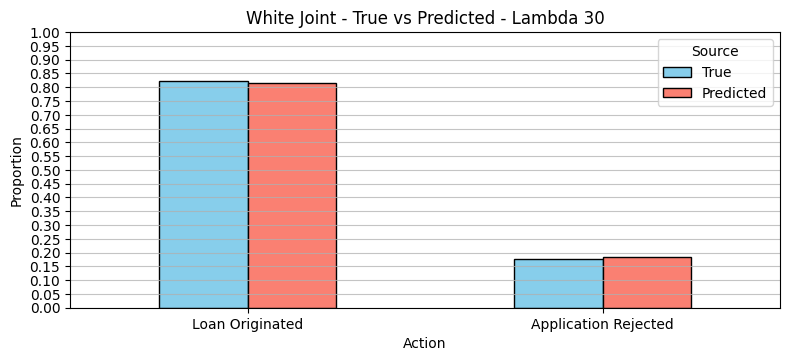

Asian Joint:
target
Loan Originated         0.815201
Application Rejected    0.184799
Name: proportion, dtype: float64



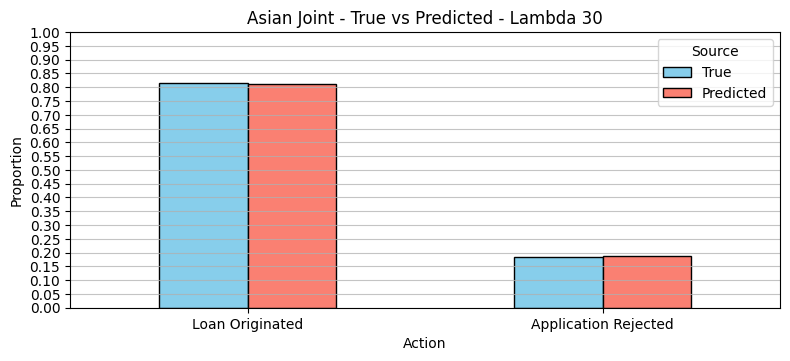

Overall: 
target
Loan Originated         0.759209
Application Rejected    0.240791
Name: proportion, dtype: float64
Black Women:
target
Loan Originated         0.648267
Application Rejected    0.351733
Name: proportion, dtype: float64



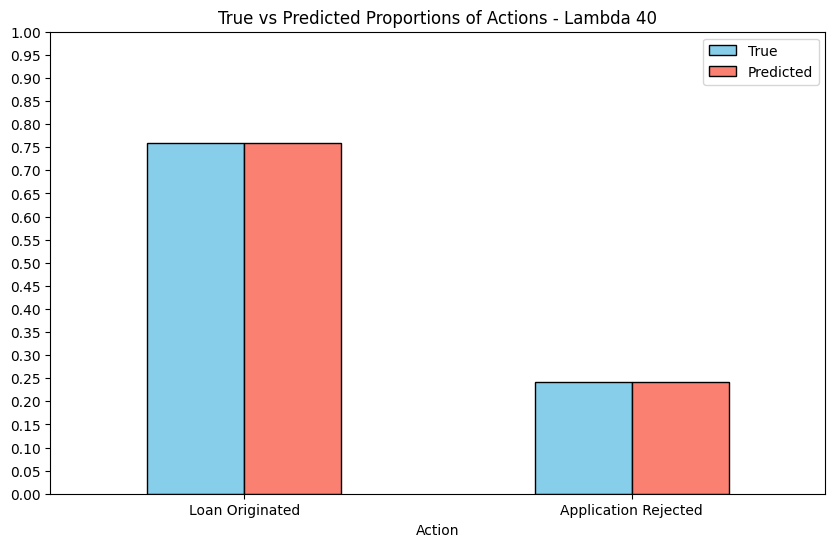

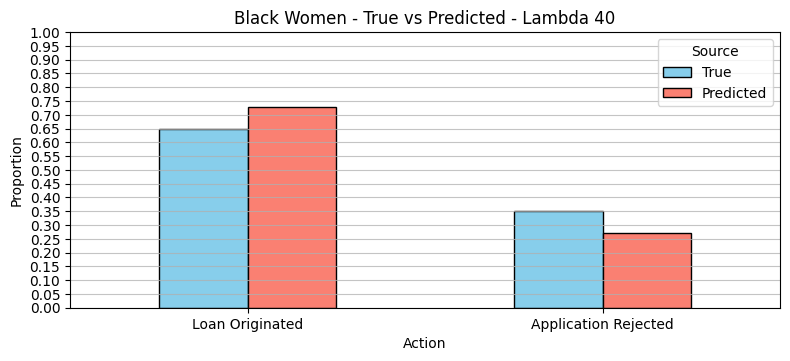

White Women:
target
Loan Originated         0.740542
Application Rejected    0.259458
Name: proportion, dtype: float64



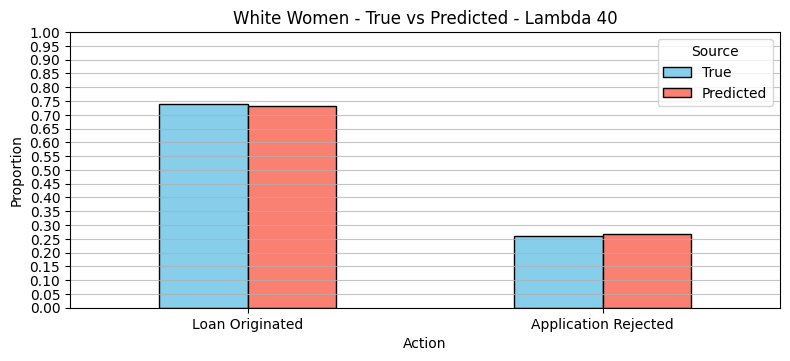

Asian Women:
target
Loan Originated         0.727686
Application Rejected    0.272314
Name: proportion, dtype: float64



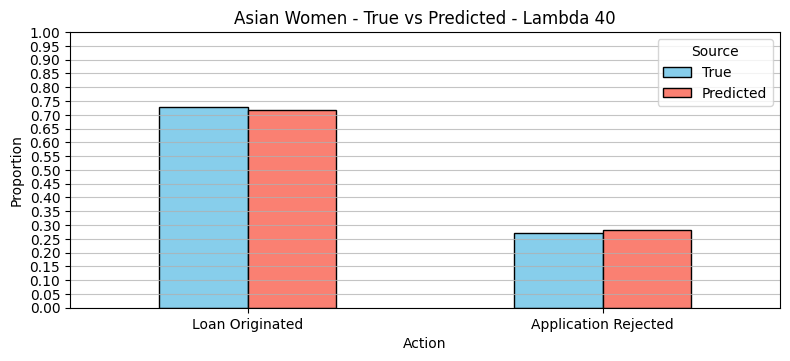

Black Men:
target
Loan Originated         0.622837
Application Rejected    0.377163
Name: proportion, dtype: float64



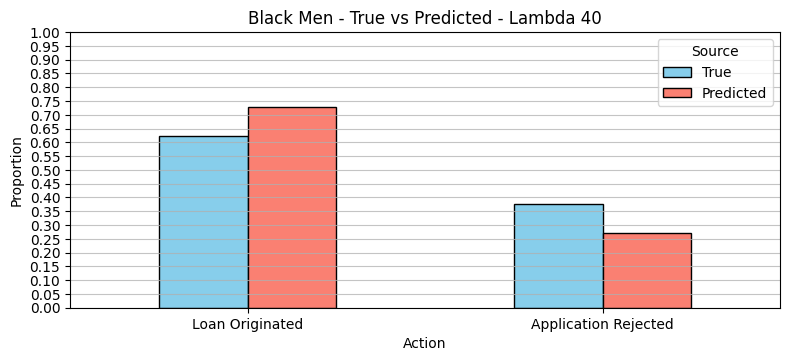

White Men:
target
Loan Originated         0.722302
Application Rejected    0.277698
Name: proportion, dtype: float64



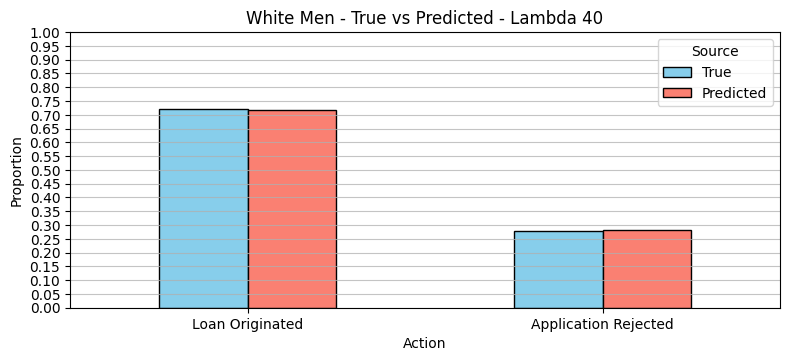

Asian Men:
target
Loan Originated         0.733085
Application Rejected    0.266915
Name: proportion, dtype: float64



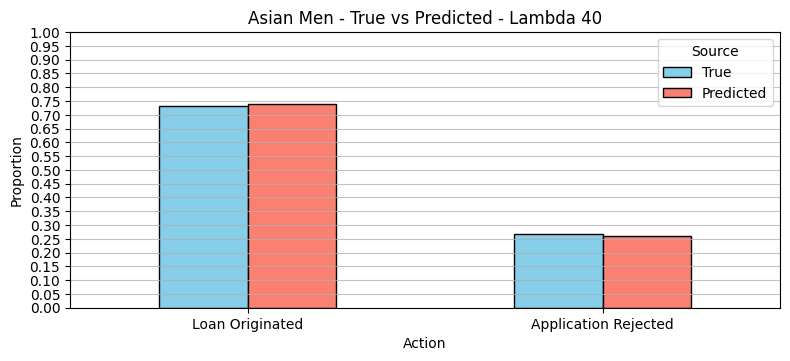

Black Joint:
target
Loan Originated         0.723206
Application Rejected    0.276794
Name: proportion, dtype: float64



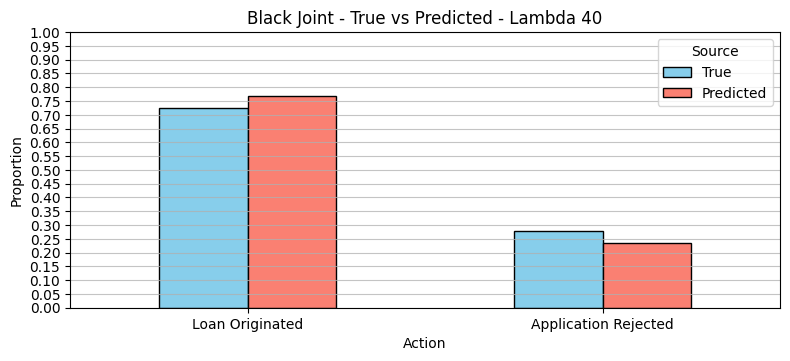

White Joint:
target
Loan Originated         0.822521
Application Rejected    0.177479
Name: proportion, dtype: float64



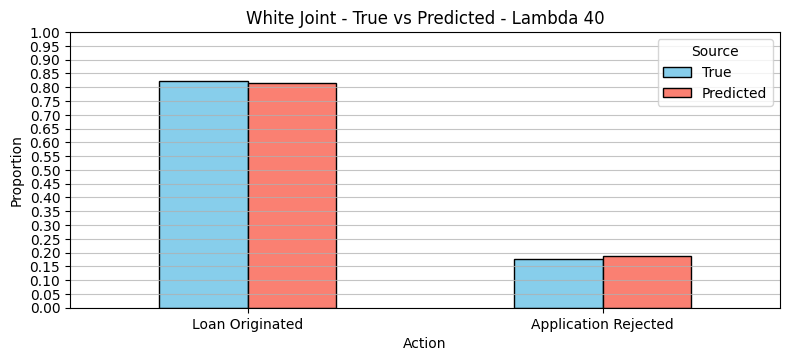

Asian Joint:
target
Loan Originated         0.815201
Application Rejected    0.184799
Name: proportion, dtype: float64



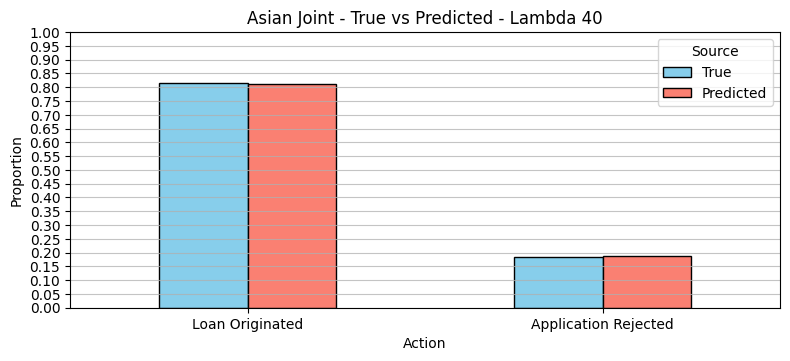

Overall: 
target
Loan Originated         0.759209
Application Rejected    0.240791
Name: proportion, dtype: float64
Black Women:
target
Loan Originated         0.648267
Application Rejected    0.351733
Name: proportion, dtype: float64



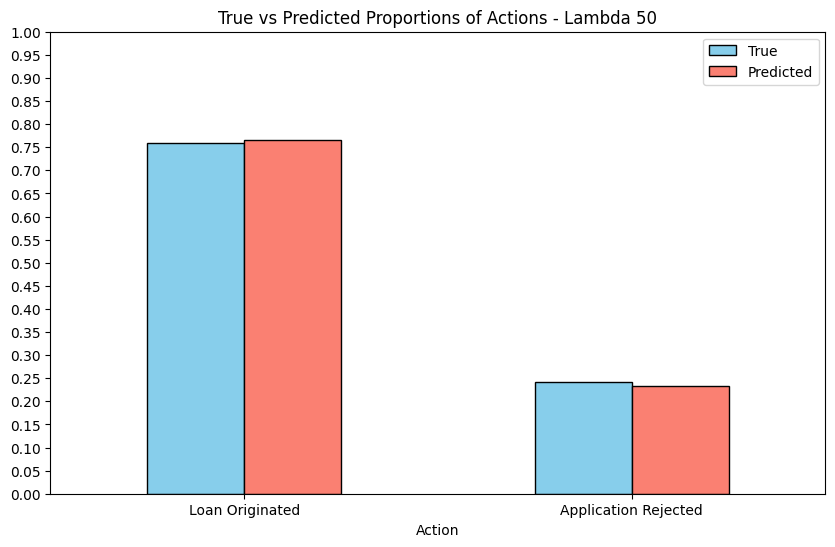

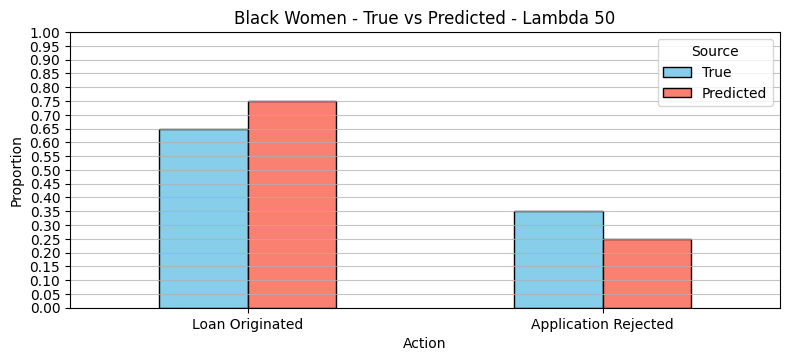

White Women:
target
Loan Originated         0.740542
Application Rejected    0.259458
Name: proportion, dtype: float64



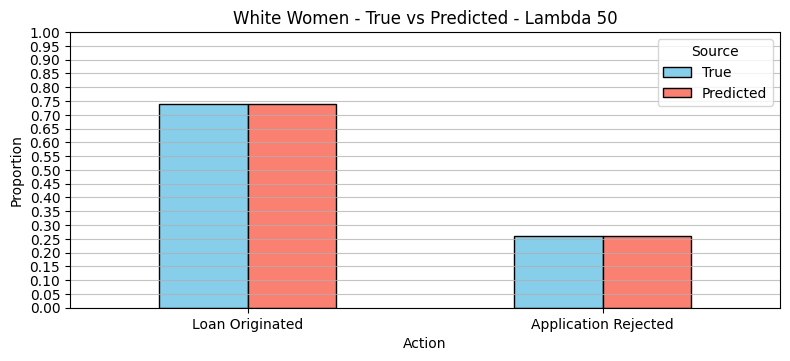

Asian Women:
target
Loan Originated         0.727686
Application Rejected    0.272314
Name: proportion, dtype: float64



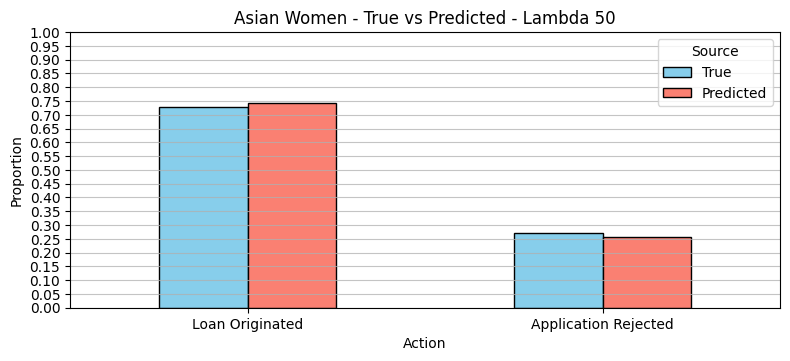

Black Men:
target
Loan Originated         0.622837
Application Rejected    0.377163
Name: proportion, dtype: float64



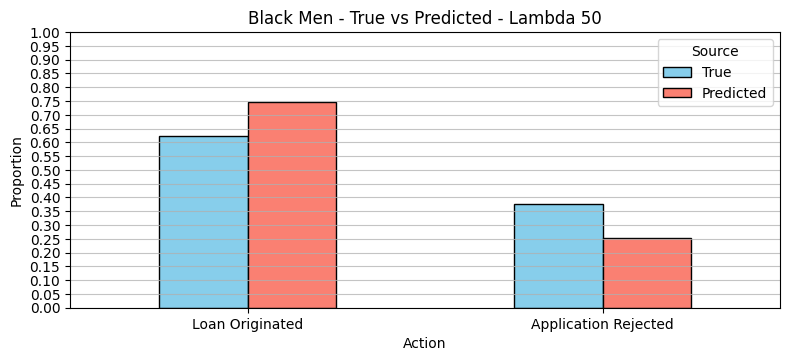

White Men:
target
Loan Originated         0.722302
Application Rejected    0.277698
Name: proportion, dtype: float64



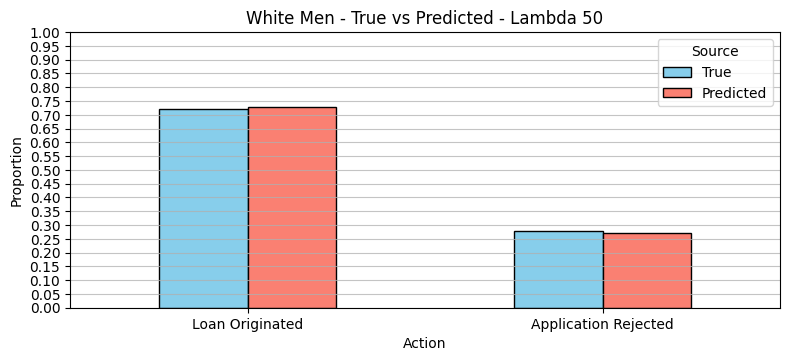

Asian Men:
target
Loan Originated         0.733085
Application Rejected    0.266915
Name: proportion, dtype: float64



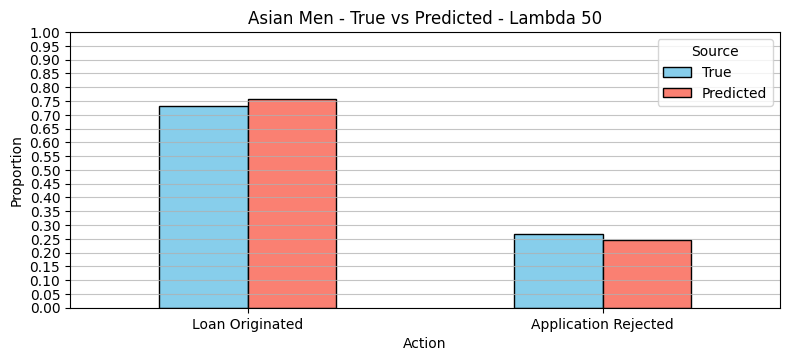

Black Joint:
target
Loan Originated         0.723206
Application Rejected    0.276794
Name: proportion, dtype: float64



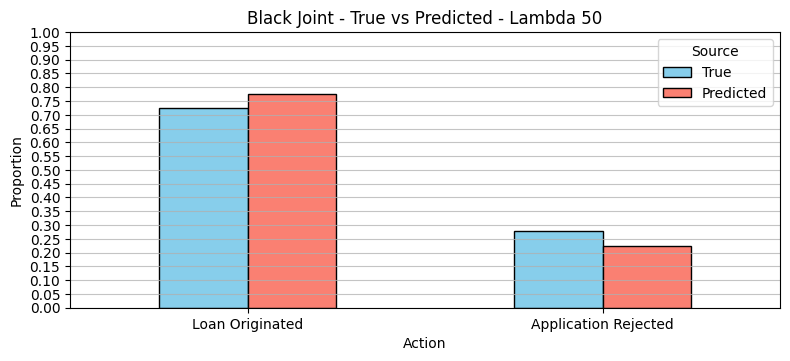

White Joint:
target
Loan Originated         0.822521
Application Rejected    0.177479
Name: proportion, dtype: float64



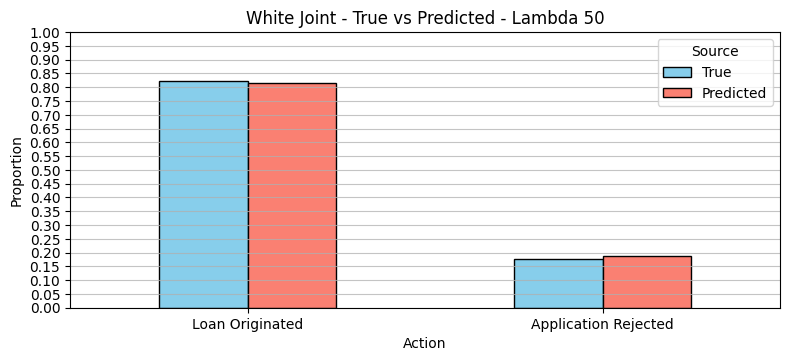

Asian Joint:
target
Loan Originated         0.815201
Application Rejected    0.184799
Name: proportion, dtype: float64



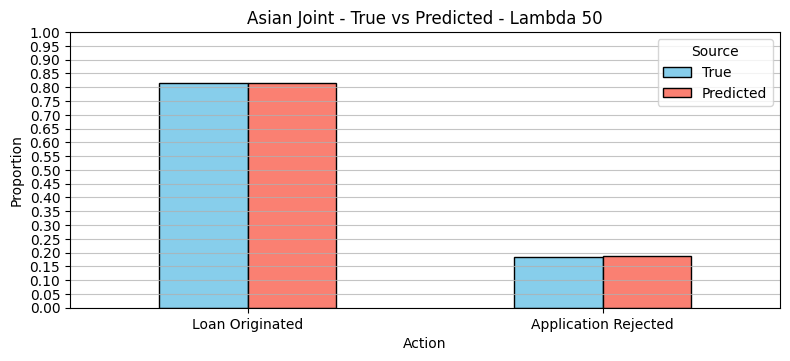

In [339]:
# So now I want to try and make an independent model. So note that this does not mean simply removing race and sex from the inputs.
# We want our model to have generally the same output distribution among all demographic groups.


train = True
lambda_fairnesses = [0, 1, 2, 5, 10, 20, 30, 40, 50]
RACE_WHITE = feature_names.index('race_White')
RACE_BLACK = feature_names.index('race_Black')
RACE_ASIAN = feature_names.index('race_Asian')
SEX_MALE = feature_names.index('sex_Male')
SEX_FEMALE = feature_names.index('sex_Female')
SEX_JOINT = feature_names.index('sex_Joint')
for lambda_fairness in lambda_fairnesses:
    model, criterion, optimizer = instantiate_model()
    model_save_filepath = f'independent_deviations/independentCNN_{research}_{lambda_fairness}'
    if Path(model_save_filepath).exists():
        model.load_state_dict(torch.load(model_save_filepath, weights_only=True))
    elif(train):
        min_loss = float('inf')
        max_epochs = 100
        max_epochs_without_improvement = 5
        current_epochs_without_improvement = 0
        
        for epoch in range(max_epochs):
            model.train()
            epoch_loss = 0.0
            for inputs, labels in train_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # === Fairness penalty (deviation from group mean) ===
                group_preds = []
                for race_idx in [RACE_WHITE, RACE_BLACK, RACE_ASIAN]:
                    for sex_idx in [SEX_MALE, SEX_FEMALE]:
                        mask = (inputs[:, 0, race_idx] > 0) & (inputs[:, 0, sex_idx] > 0)
                        if mask.any():
                            group_preds.append(outputs[mask].mean())
                group_preds_tensor = torch.stack(group_preds)
                group_mean = group_preds_tensor.mean()
                fairness_penalty = torch.mean((group_preds_tensor - group_mean) ** 2)
                loss += lambda_fairness * fairness_penalty

                # === Standard training steps ===
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            print(f"Lambda: {lambda_fairness} - Epoch {epoch + 1} - Loss: {epoch_loss:.4f}")

            if(epoch_loss < min_loss):
                torch.save(model.state_dict(), model_save_filepath)
                min_loss = epoch_loss
                current_epochs_without_improvement = 0
                print("Saved model")
            else:
                current_epochs_without_improvement += 1
                if current_epochs_without_improvement > max_epochs_without_improvement:
                    print("Stopped training")
                    break
    evaluate_independence(model_save_filepath,lambda_fairness)


In [340]:
# Evaluate
for lambda_fairness in lambda_fairnesses:
    model.load_state_dict(torch.load(f'independent_deviations/independentCNN_{research}_{lambda_fairness}', weights_only=True))
    print(f"Lambda: {lambda_fairness}: ")
    evaluate(verbose=True)


Lambda: 0: 
Accuracy: 0.973607912207018, 
AUC: 0.9962461929289375, 
Precision: 0.9871042109434098,
Recall: 0.9780149184481959, 
F1: 0.9825385442811043
Lambda: 1: 
Accuracy: 0.9735808156076412, 
AUC: 0.9961728688380703, 
Precision: 0.9873495278598717,
Recall: 0.9777293979085621, 
F1: 0.9825159150004483
Lambda: 2: 
Accuracy: 0.9732014632163664, 
AUC: 0.9960018408780955, 
Precision: 0.9867814435960236,
Recall: 0.9778007780434705, 
F1: 0.9822705842281698
Lambda: 5: 
Accuracy: 0.9724156618344397, 
AUC: 0.9958128433748179, 
Precision: 0.9854025096178046,
Recall: 0.9781576787180127, 
F1: 0.9817667287577017
Lambda: 10: 
Accuracy: 0.9712776046606151, 
AUC: 0.995601817717708, 
Precision: 0.9839167115419135,
Recall: 0.9781576787180127, 
F1: 0.9810287432437269
Lambda: 20: 
Accuracy: 0.9703292236824279, 
AUC: 0.9952889392111074, 
Precision: 0.9834099396725079,
Recall: 0.977408187301474, 
F1: 0.9803998782823492
Lambda: 30: 
Accuracy: 0.9697601950955155, 
AUC: 0.9952191054048026, 
Precision: 0.981908